In [1]:
import os
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# saving models
from sklearn.externals import joblib

# incase we want to try some cleaning steps to see if it improves the model
import Clean_Function_Helpers as cfh

/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
if not os.path.isdir('saved_models/'):
    os.mkdir('saved_models')
if not os.path.isdir('saved_models/regular/'):
    os.mkdir('saved_models/regular/')
if not os.path.isdir('saved_models/undersampled/'):
    os.mkdir('saved_models/undersampled/')
if not os.path.isdir('saved_models/oversampled/'):
    os.mkdir('saved_models/oversampled/')

In [3]:
plt.rcParams['figure.figsize'] = (9,6)
sns.set_style('darkgrid')

SEED = 1111

In [4]:
# helper functions
def get_weights(ser):
    """
    Weighs observations so that they can be
    sampled in such a way as to result in even distributions.
    Used in following function to oversample minority class of a dataset.
    """
    vcs = ser.value_counts()
    class_labels = vcs.index.tolist()
    class_sizes = vcs.values
    nclasses = len(class_labels)
    class_weights = dict(zip(class_labels,(nclasses**-1/class_sizes)))
    return class_weights


def pr_curve(y_actual, y_pred, digit_prec=2):
    '''
    PLOTS THE PRECISION VS RECAL OF A LOG REG ESTIMATOR
    OVER A RANGE OF THRESHOLDS

    Y_PRED MUST BE PREDICTED PROBABILITY VECTOR OF ONE CLASS (EG PROBS[:,1])
    MUST ALL BE OF TYPE INT OR FLOAT

    RETURNS: recalls, precisions, thresholds

    '''
    threshvec = np.unique(np.round(y_pred,digit_prec))
    numthresh = len(threshvec)
    tpvec = np.zeros(numthresh)
    fpvec = np.zeros(numthresh)
    fnvec = np.zeros(numthresh)

    for i in range(numthresh):
        thresh = threshvec[i]
        tpvec[i] = sum(y_actual[y_pred>=thresh])
        fpvec[i] = sum(1-y_actual[y_pred>=thresh])
        fnvec[i] = sum(y_actual[y_pred<thresh])
    recallvec = tpvec/(tpvec + fnvec)
    precisionvec = tpvec/(tpvec + fpvec)
    plt.plot(precisionvec,recallvec)
    plt.axis([0, 1, 0, 1])
    plt.xlabel("precision")
    plt.ylabel("recall")
    return (recallvec, precisionvec, threshvec)

def calc_f1(recalls, precisions):
    return (2*recalls*precisions)/(recalls + precisions)

## Overview

Taking two different approaches. 

    1. Try to model the difference between real and fraudulent charges.
        - Classifiers like Logistic Regression, NaiveBayes, Tree Ensembles etc
        - Sampling approaches over vs undersampling
    2. Try to identify core boundary of real charges and identify anything outside this boundary as fraudulent.
        - Covariance estimates, Local Outlier Factor, Clustering, One Class SVM, Hierarchical Clustering, 
        Model-based bayesian clustering.
        
This notebook focuses on the first approach: using classification algorithms to predict fraudulent charges.

### Read Data

In [5]:
df = pd.read_csv('creditcard.csv')
df.Class.value_counts()/df.Class.value_counts().sum()

0    0.998273
1    0.001727
Name: Class, dtype: float64

### Classifiers

Here we cross-validate a few classifiers on the raw data via the following steps:

    1. Take a small sample of the data set for training. This both reduces training time and gives us a large test set for validation. Make sure the Class proportions are the same in the sample as the test dataset.
        * Note that the training set has only about 100 fraudulent cases in it.
    2. Fit a classifier using Cross-validated grid search on the training set.
    3. Use the final estimator to make predictions on the test set and calculate precision and recall.

In [6]:
def get_sample(df, n=None, frac=None, n_oversample=False, n_undersample=False):
    """
    Generate Train and Test samples of specified size with the option
    to oversample or undersample.
    """
    if n_oversample:
        # split out classes
        c0 = df[df.Class==0].sample(n = n_oversample//2, random_state = SEED)
        # sample half of the minority class
        c1 = df[df.Class==1].sample(frac=0.5, random_state = SEED)
        # sample the minority class W REPLACEMENT
        c1 = c1.sample(n_oversample//2, replace=True, random_state=SEED)
        # join them together
        train = pd.concat([c0,c1])
        test = df[~df.index.isin(train.index)]
        print('Train Distribution of Target Class')
        print(train.Class.value_counts())
        return train, test
    elif n_undersample:
        # take `n_undersample` observations from each class
        idx0 = df[df.Class==0].sample(n = n_undersample, random_state = SEED).index.tolist()
        idx1 = df[df.Class==1].sample(n = n_undersample, random_state = SEED).index.tolist()
        tidx = idx0 + idx1
        train = df.loc[tidx].copy() 
        test = df[~df.index.isin(tidx)]
        print('Train Distribution of Target Class')
        print(train.Class.value_counts())
        return train, test
    else:
        train = df.sample(n=n, frac=frac, random_state=SEED)
        test = df[~df.index.isin(train.index)]
        print('Train Distribution of Target Class')
        print(train.Class.value_counts())
        return train, test

def evaluate_classifier(train_data, test_data, clf, params, cv=4, scoring='roc_auc'):
    '''
    Takes grid searches parameters for a passed classifier and evaluates 
    on the test set.
    '''
    x = train_data.drop(['Time','Class'], axis=1)
    y = train_data.Class

    # grid search parameters
    grid = GridSearchCV(clf, params, cv=cv, scoring=scoring, n_jobs=-1)
    grid.fit(x,y)
    print('Best Params:', grid.best_params_)
    print('Best Score:', grid.best_score_)

    # get best estimator and scores
    mod = grid.best_estimator_
    # run predictions on test set
    pred_proba = mod.predict_proba(test_data[x.columns])
    preds = mod.predict(test_data[x.columns])
    
    # plot pr curve
    r,p,t = pr_curve(test_data.Class, pred_proba[:,1]);
    
    # find threshold that maximizes f1 score
    idx = np.argmax(calc_f1(r[:-1],p[:-1]))
    stats = {
        'auc': grid.best_score_,
        'f1': calc_f1(r[idx], p[idx]),
        'recall': r[idx],
        'precision': p[idx],
        'threshold': t[idx]
    }
    print('F1:', calc_f1(r[idx], p[idx]))
    print('Recall:', r[idx])
    print('Precision:', p[idx])
    print('Threshold:', t[idx])
    return mod, x, y, stats

In [7]:
# We will test different transforms of the data

sub_cols = df.columns.drop(['Time', 'Class'])

scaled_df = cfh.scale_data(df, MinMaxScaler(), sub_cols)
deskewed = cfh.deskew_df(scaled_df, topn=10)

# OUTLIERS CAN ONLY BE REMOVED ON TRAINING SET!!!
# no_ol = cfh.remove_outliers(scaled_df, S=5, subset_rows=df.Class==0, subset_cols=sub_cols)
# deskewed_no_ol = cfh.remove_outliers(deskewed, S=5, subset_rows=df.Class==0, subset_cols=sub_cols)
# no_ol_deskewed = cfh.deskew_df(no_ol, topn=10)

In [8]:
# Parameters for grid search
lr_params = {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 0.5, 1, 10]}

priors = [(p, 1-p) for p in np.arange(0.1, 1, 0.1)]
nb_params = {'priors': priors}


class_weights = [{0:p, 1:1-p} for p in [0.1, 0.25, 0.5, 0.75, 0.9]]
tree_params = {
    'n_estimators': [10, 50,100, 150, 250],
    'max_depth': [3,5,10,15,25],
    'criterion': ['gini', 'entropy'],
    'class_weight': class_weights
}


knn_params = {
    'n_neighbors': [1,3,5,10,15,25],
    'weights': ['uniform', 'distance']
}

In [9]:
results = {}

EVALUATING: Regular -- LogisticRegression

Train Distribution of Target Class
0    56859
1      102
Name: Class, dtype: int64

Best Params: {'C': 0.5, 'penalty': 'l1'}
Best Score: 0.971642661409476
F1: 0.7774869109947644
Recall: 0.7615384615384615
Precision: 0.7941176470588235
Threshold: 0.11

EVALUATING: Regular -- GaussianNB

Train Distribution of Target Class
0    56859
1      102
Name: Class, dtype: int64



/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


Best Params: {'priors': (0.6, 0.4)}
Best Score: 0.9470458159297814
F1: 0.11557610241820768
Recall: 0.8333333333333334
Precision: 0.06209400076423385
Threshold: 0.99

EVALUATING: Regular -- RandomForestClassifier

Train Distribution of Target Class
0    56859
1      102
Name: Class, dtype: int64

Best Params: {'class_weight': {0: 0.75, 1: 0.25}, 'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 250}
Best Score: 0.9729742351631855
F1: 0.8317373461012312
Recall: 0.7794871794871795
Precision: 0.8914956011730205
Threshold: 0.29

EVALUATING: Regular -- ExtraTreesClassifier

Train Distribution of Target Class
0    56859
1      102
Name: Class, dtype: int64

Best Params: {'class_weight': {0: 0.25, 1: 0.75}, 'criterion': 'gini', 'max_depth': 15, 'n_estimators': 150}
Best Score: 0.9768135715109562
F1: 0.8437917222963953
Recall: 0.8102564102564103
Precision: 0.8802228412256268
Threshold: 0.19

EVALUATING: Regular -- KNeighborsClassifier

Train Distribution of Target Class
0    56859
1     

/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


Best Params: {'priors': (0.6, 0.4)}
Best Score: 0.9471242424061197
F1: 0.11555555555555556
Recall: 0.8333333333333334
Precision: 0.06208213944603629
Threshold: 0.99

EVALUATING: Scaled -- RandomForestClassifier

Train Distribution of Target Class
0    56859
1      102
Name: Class, dtype: int64

Best Params: {'class_weight': {0: 0.75, 1: 0.25}, 'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 250}
Best Score: 0.9708931690205137
F1: 0.8328840970350404
Recall: 0.7923076923076923
Precision: 0.8778409090909091
Threshold: 0.25

EVALUATING: Scaled -- ExtraTreesClassifier

Train Distribution of Target Class
0    56859
1      102
Name: Class, dtype: int64

Best Params: {'class_weight': {0: 0.25, 1: 0.75}, 'criterion': 'gini', 'max_depth': 15, 'n_estimators': 150}
Best Score: 0.9768135715109562
F1: 0.8437917222963953
Recall: 0.8102564102564103
Precision: 0.8802228412256268
Threshold: 0.19

EVALUATING: Scaled -- KNeighborsClassifier

Train Distribution of Target Class
0    56859
1      10

/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


Best Params: {'priors': (0.9, 0.09999999999999998)}
Best Score: 0.9493024522409454
F1: 0.11283842794759825
Recall: 0.8282051282051283
Precision: 0.060543580131208995
Threshold: 0.99

EVALUATING: De-Skewed -- RandomForestClassifier

Train Distribution of Target Class
0.0    56859
1.0      102
Name: Class, dtype: int64

Best Params: {'class_weight': {0: 0.75, 1: 0.25}, 'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 250}
Best Score: 0.9708574786501638
F1: 0.832214765100671
Recall: 0.7948717948717948
Precision: 0.8732394366197183
Threshold: 0.23

EVALUATING: De-Skewed -- ExtraTreesClassifier

Train Distribution of Target Class
0.0    56859
1.0      102
Name: Class, dtype: int64

Best Params: {'class_weight': {0: 0.9, 1: 0.09999999999999998}, 'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 250}
Best Score: 0.9781458021950867
F1: 0.8409703504043126
Recall: 0.8
Precision: 0.8863636363636364
Threshold: 0.2

EVALUATING: De-Skewed -- KNeighborsClassifier

Train Distribution of

/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Best Params: {'C': 10, 'penalty': 'l1'}
Best Score: 0.9767378711082503
F1: 0.8042328042328043
Recall: 0.7794871794871795
Precision: 0.8306010928961749
Threshold: 0.83

EVALUATING: De-Skewed - No Outliers -- GaussianNB

Train Distribution of Target Class
0.0    56859
1.0      102
Name: Class, dtype: int64



/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Best Params: {'priors': (0.9, 0.09999999999999998)}
Best Score: 0.956711950087888
F1: 0.06228893058161351
Recall: 0.8512820512820513
Precision: 0.032327166504381694
Threshold: 0.99

EVALUATING: De-Skewed - No Outliers -- RandomForestClassifier

Train Distribution of Target Class
0.0    56859
1.0      102
Name: Class, dtype: int64



/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Best Params: {'class_weight': {0: 0.1, 1: 0.9}, 'criterion': 'gini', 'max_depth': 10, 'n_estimators': 250}
Best Score: 0.9719113984057767
F1: 0.8132450331125828
Recall: 0.7871794871794872
Precision: 0.8410958904109589
Threshold: 0.51

EVALUATING: De-Skewed - No Outliers -- ExtraTreesClassifier

Train Distribution of Target Class
0.0    56859
1.0      102
Name: Class, dtype: int64



/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Best Params: {'class_weight': {0: 0.5, 1: 0.5}, 'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 250}
Best Score: 0.9800248889819662
F1: 0.8125000000000001
Recall: 0.7666666666666667
Precision: 0.8641618497109826
Threshold: 0.62

EVALUATING: De-Skewed - No Outliers -- KNeighborsClassifier

Train Distribution of Target Class
0.0    56859
1.0      102
Name: Class, dtype: int64



/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Best Params: {'n_neighbors': 25, 'weights': 'distance'}
Best Score: 0.911100827725769
F1: 0.8161073825503355
Recall: 0.7794871794871795
Precision: 0.856338028169014
Threshold: 0.18



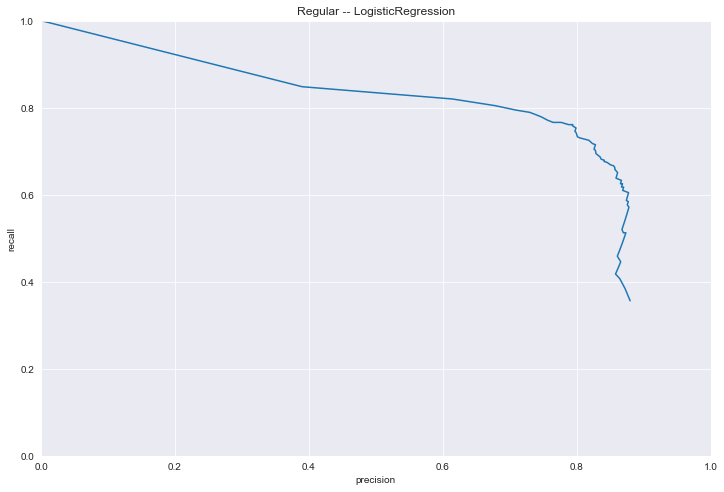

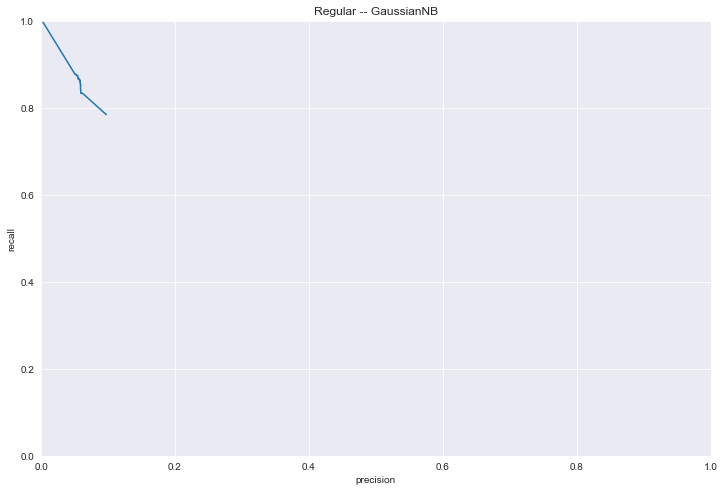

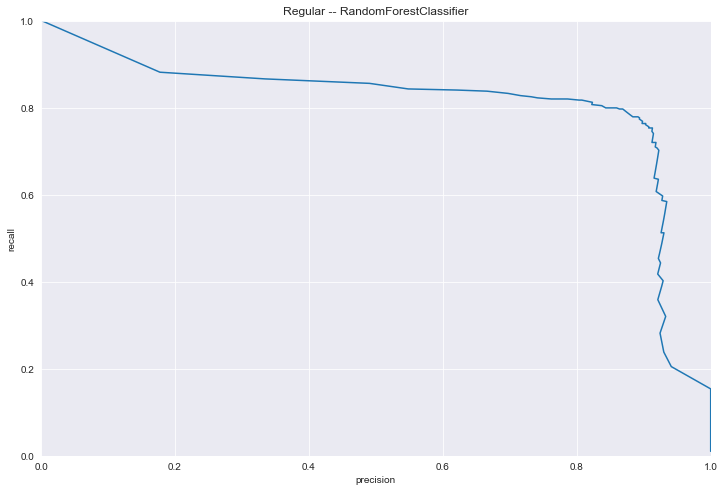

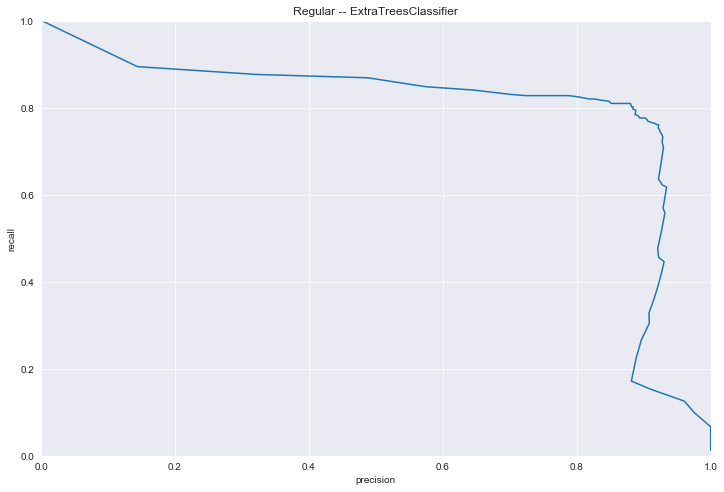

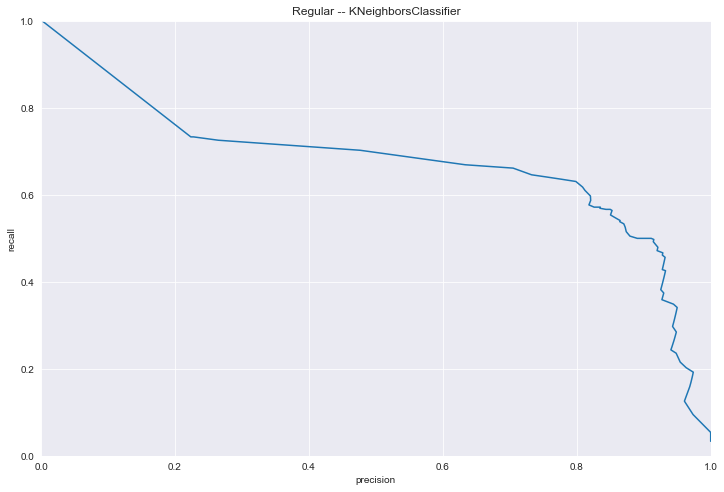

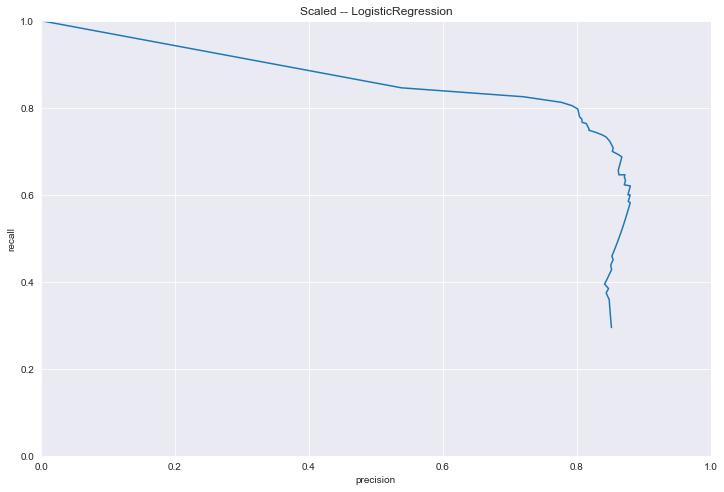

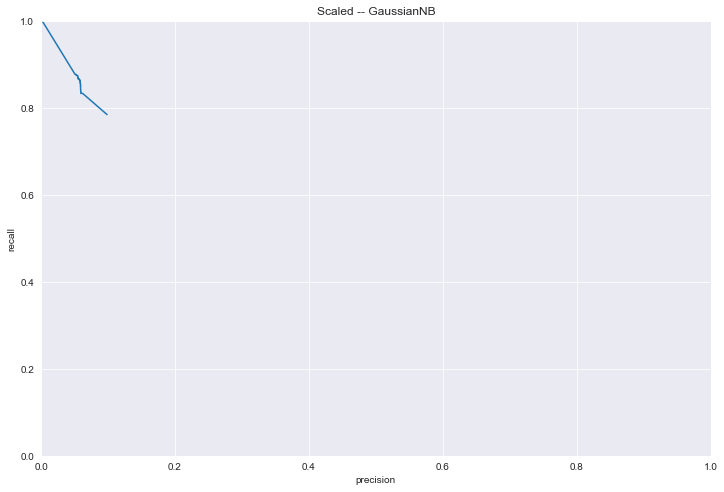

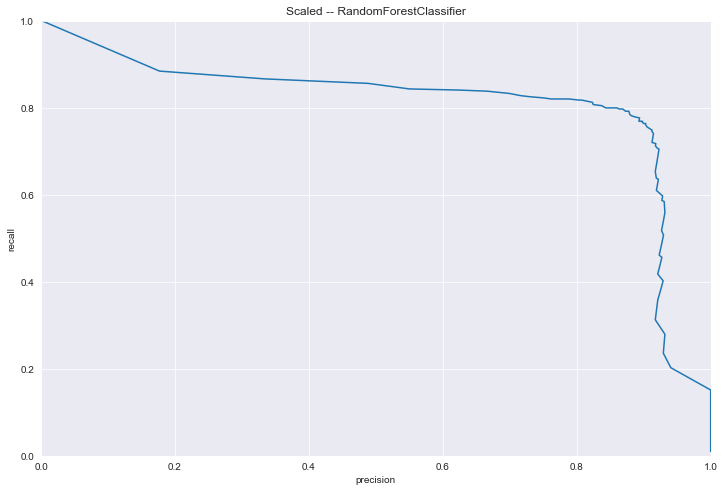

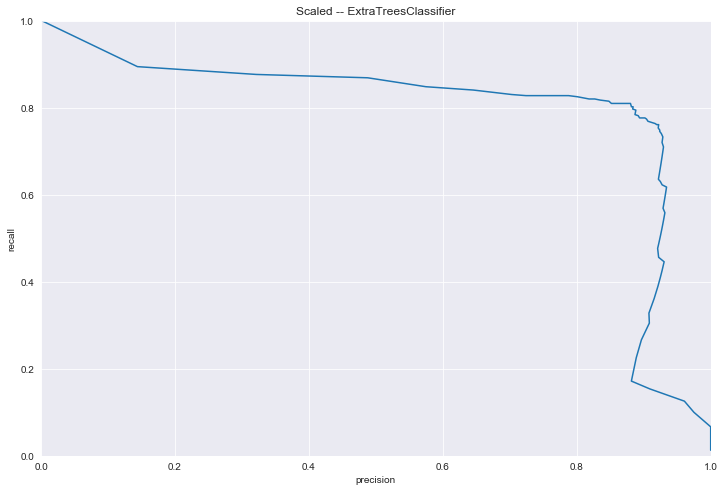

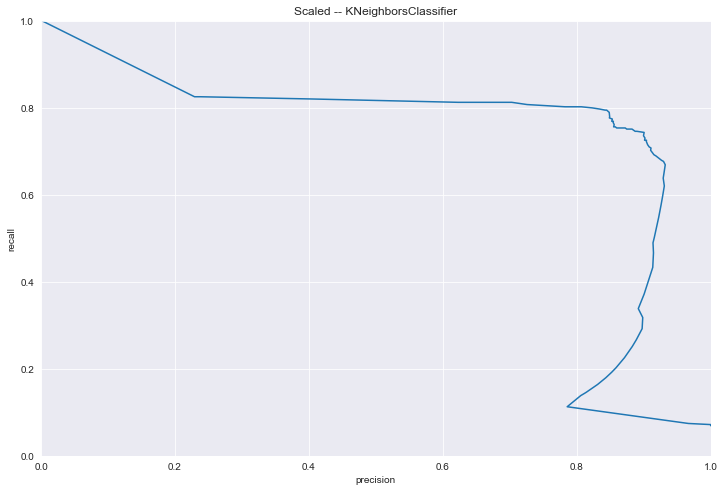

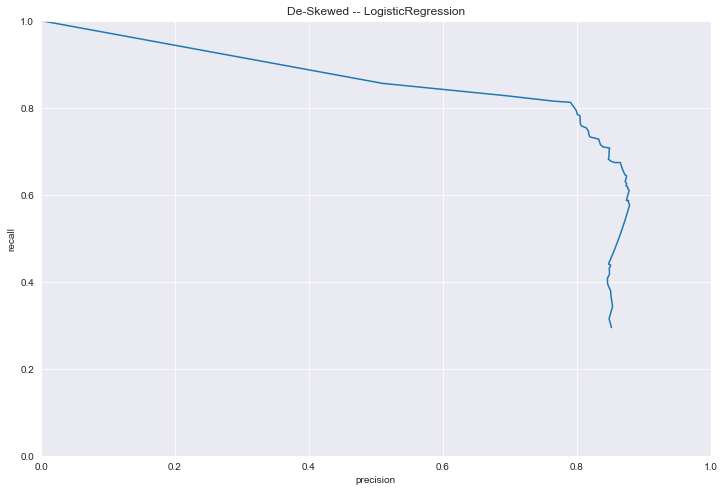

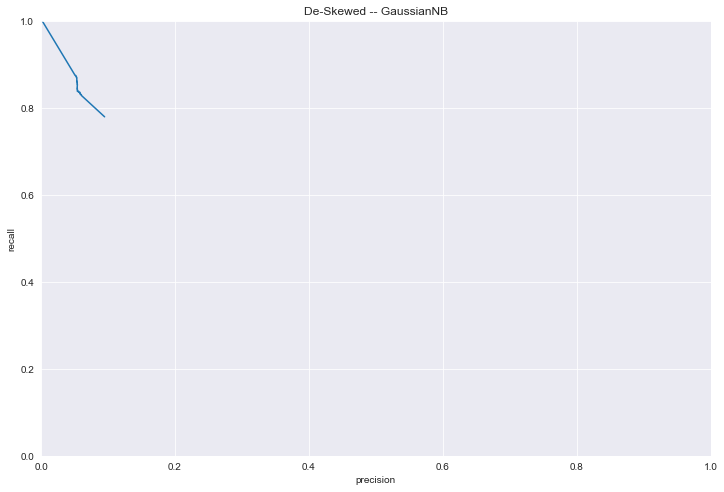

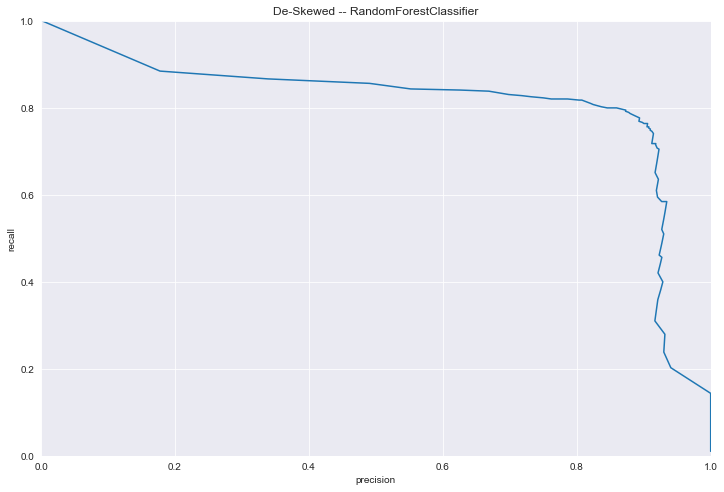

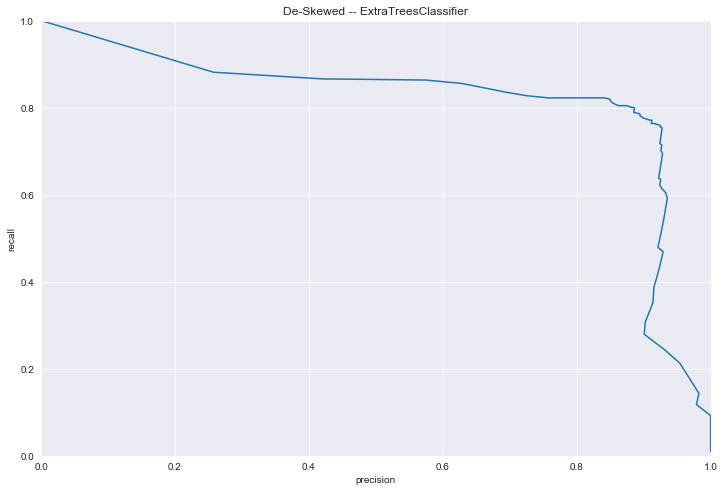

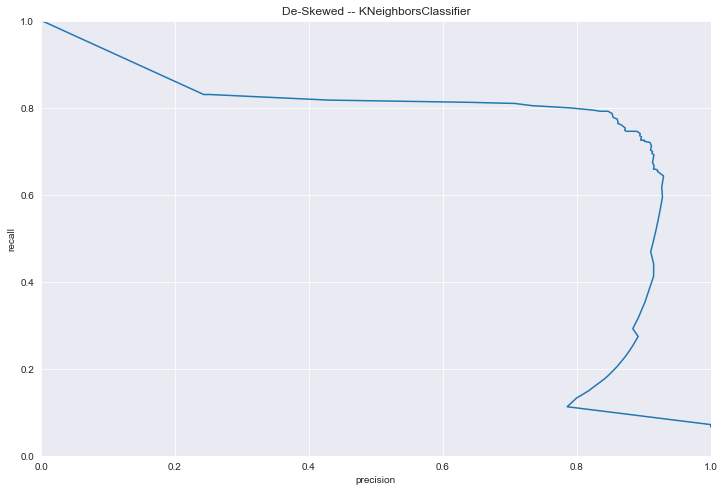

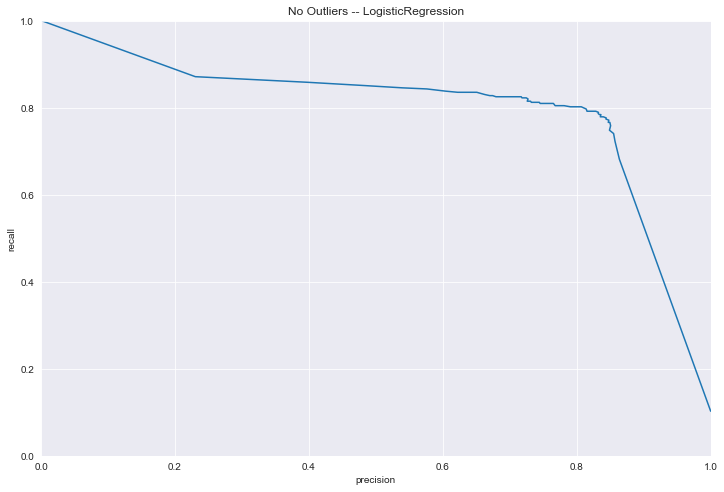

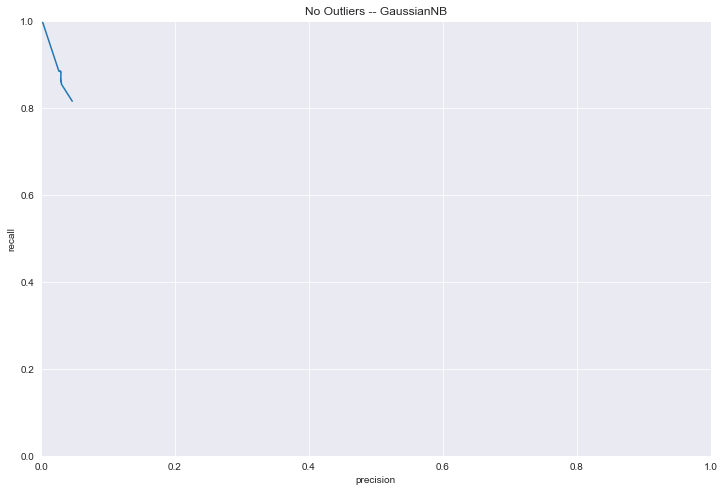

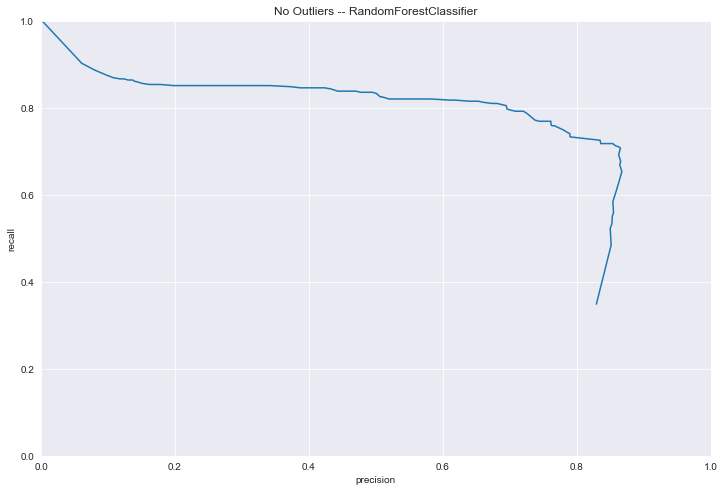

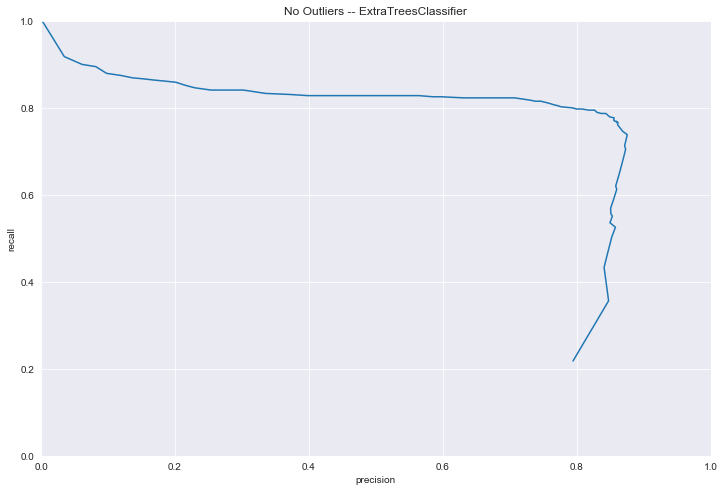

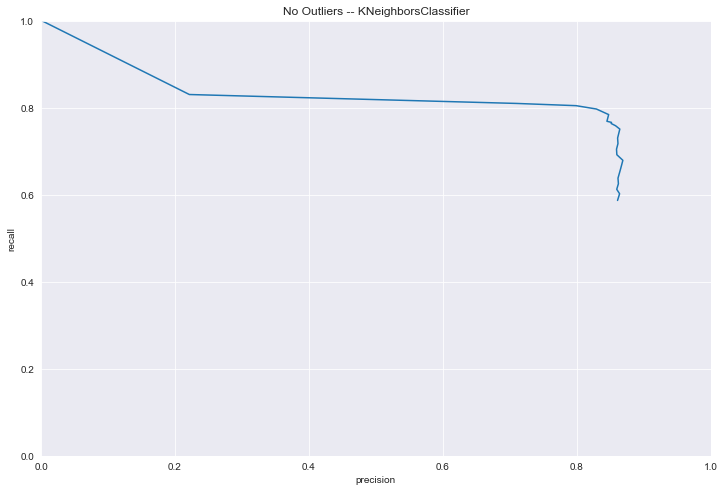

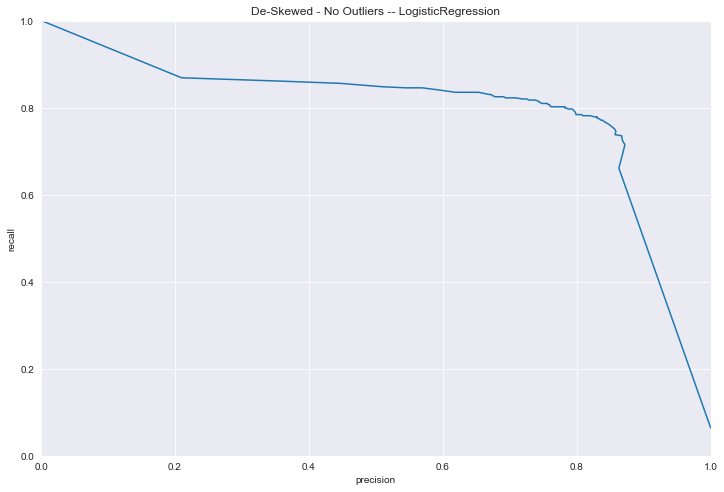

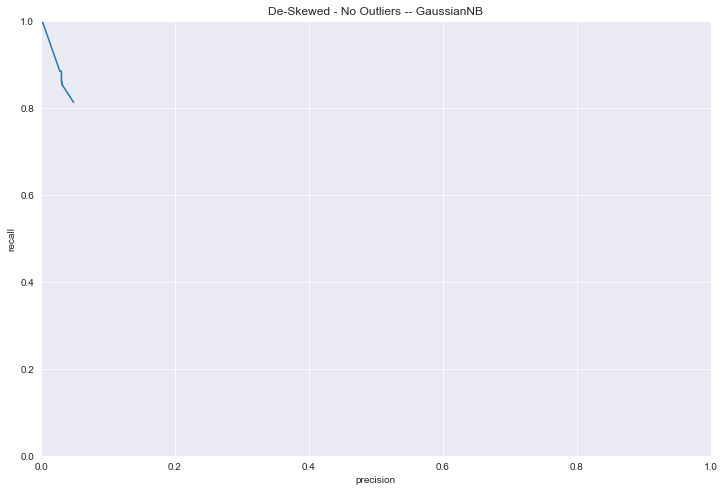

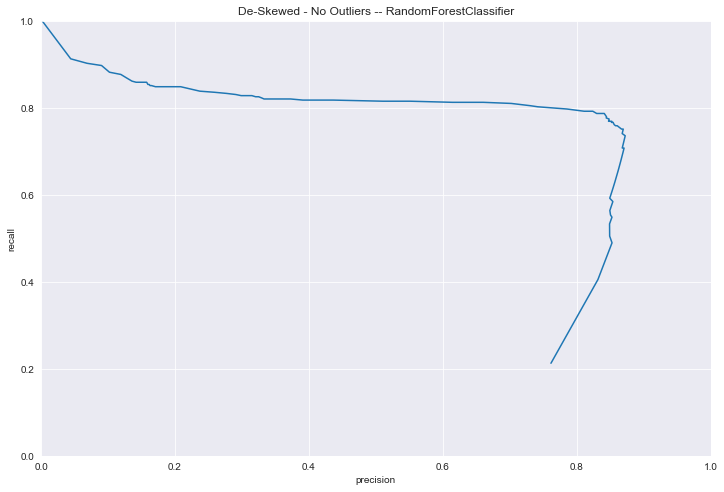

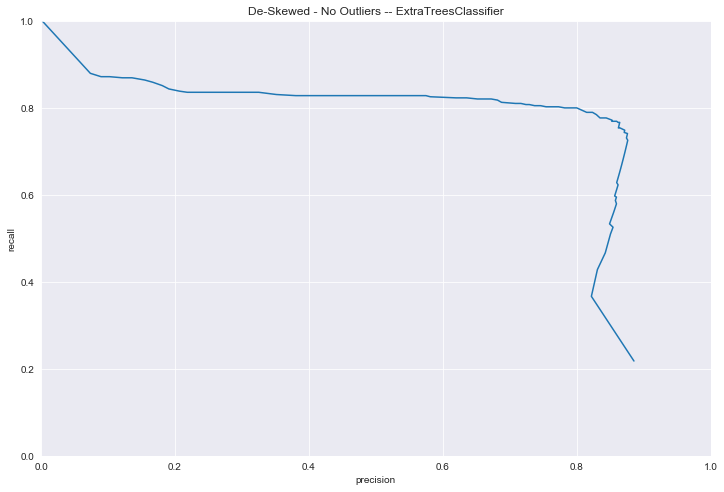

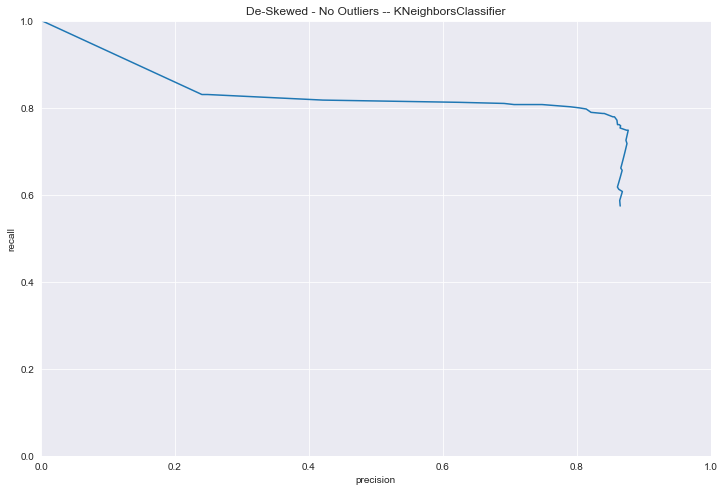

In [10]:
for data_transformed, transform_label in zip([df, scaled_df, deskewed, scaled_df, deskewed],
                                             ['Regular', 'Scaled', 'De-Skewed', 'No Outliers', 'De-Skewed - No Outliers']):
    for clf, params in zip(
        [
            LogisticRegression(), 
            GaussianNB(), 
            RandomForestClassifier(random_state = SEED),
            ExtraTreesClassifier(random_state = SEED),
            KNeighborsClassifier()
        ],
        [
            lr_params, 
            nb_params,
            tree_params,
            tree_params,
            knn_params
            
        ]
        
    ):
        model_name = str(clf.__class__).split('.')[-1].strip("'>")
        label = transform_label + ' -- ' + model_name
        print('EVALUATING:', label)
        print()
        
        # get samples and potentially remove outliers for related transforms
        train_reg, test_reg = get_sample(data_transformed, frac=0.2)
        if transform_label in ['No Outliers', 'De-Skewed - No Outliers']:
            train_reg = cfh.remove_outliers(train_reg, S=5, subset_rows=train_reg.Class==0, subset_cols=sub_cols)
        print()
        plt.figure(figsize=(12,8))
        mod, x, y, stats = evaluate_classifier(train_reg, test_reg, clf, params)
        plt.title(label)
        results[label] = (mod,x,y,stats)
        print('===================================================')
        print('===================================================')
        print()

In [11]:
# Save Results
for k, (mod,x,y,stats) in results.items():
    joblib.dump(mod, 'saved_models/regular/'+k+'.joblib')
    with open('saved_models/regular/'+k+' Stats.json', 'w') as f:
        json.dump(stats, f)

We see that all classifiers acheive a high AUC score on the data. However,
the Naive Bayes classifier suffers from it's simplicity and has very low precision on the target class (fraudulent).

Th Random Forest and Extra Trees Classifiers perform about equally and achieve a higher F1 score than the Logistic Regression.

--------------

### Sampling

We are going to perform the same steps as above except we are going to use both over and undersampling techniques
to create a training dataset.

For undersampling, we are going to create a very small training set where the distribution of classes is equal in the training set.

For oversampling, we will duplicate observations in the minority class (possibly with added gaussian noise) until the sampling distribution is equal.


___Undersample Majority___

In [12]:
del tree_params['class_weight']

In [13]:
results_us = {}

EVALUATING: Regular -- LogisticRegression

Train Distribution of Target Class
1    250
0    250
Name: Class, dtype: int64

Best Params: {'C': 0.1, 'penalty': 'l1'}
Best Score: 0.986883768561188
F1: 0.5816326530612246
Recall: 0.7066115702479339
Precision: 0.49421965317919075
Threshold: 0.99

EVALUATING: Regular -- GaussianNB

Train Distribution of Target Class
1    250
0    250
Name: Class, dtype: int64



/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


Best Params: {'priors': (0.1, 0.9)}
Best Score: 0.9584198668714798
F1: 0.05535690637001722
Recall: 0.8636363636363636
Precision: 0.028594883020933097
Threshold: 0.99

EVALUATING: Regular -- RandomForestClassifier

Train Distribution of Target Class
1    250
0    250
Name: Class, dtype: int64

Best Params: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 150}
Best Score: 0.9850506912442397
F1: 0.7430997876857749
Recall: 0.7231404958677686
Precision: 0.7641921397379913
Threshold: 0.96

EVALUATING: Regular -- ExtraTreesClassifier

Train Distribution of Target Class
1    250
0    250
Name: Class, dtype: int64

Best Params: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 50}
Best Score: 0.987031233998976
F1: 0.7106796116504853
Recall: 0.756198347107438
Precision: 0.6703296703296703
Threshold: 0.92

EVALUATING: Regular -- KNeighborsClassifier

Train Distribution of Target Class
1    250
0    250
Name: Class, dtype: int64

Best Params: {'n_neighbors': 10, 'weights': 'distance'}

/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Best Params: {'C': 10, 'penalty': 'l1'}
Best Score: 0.9865026071872681
F1: 0.3519163763066202
Recall: 0.8347107438016529
Precision: 0.2229580573951435
Threshold: 0.99

EVALUATING: De-Skewed - No Outliers -- GaussianNB

Train Distribution of Target Class
1.0    250
0.0    250
Name: Class, dtype: int64



/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Best Params: {'priors': (0.1, 0.9)}
Best Score: 0.9731526589130277
F1: 0.02502360717658168
Recall: 0.8760330578512396
Precision: 0.012693090647826607
Threshold: 0.99

EVALUATING: De-Skewed - No Outliers -- RandomForestClassifier

Train Distribution of Target Class
1.0    250
0.0    250
Name: Class, dtype: int64



/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Best Params: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 50}
Best Score: 0.9888540393115771
F1: 0.7300215982721382
Recall: 0.6983471074380165
Precision: 0.7647058823529411
Threshold: 0.98

EVALUATING: De-Skewed - No Outliers -- ExtraTreesClassifier

Train Distribution of Target Class
1.0    250
0.0    250
Name: Class, dtype: int64



/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Best Params: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 250}
Best Score: 0.9897858344566705
F1: 0.7156673114119922
Recall: 0.7644628099173554
Precision: 0.6727272727272727
Threshold: 0.92

EVALUATING: De-Skewed - No Outliers -- KNeighborsClassifier

Train Distribution of Target Class
1.0    250
0.0    250
Name: Class, dtype: int64



/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Best Params: {'n_neighbors': 25, 'weights': 'distance'}
Best Score: 0.9744876014922097
F1: 0.7339805825242718
Recall: 0.78099173553719
Precision: 0.6923076923076923
Threshold: 0.97



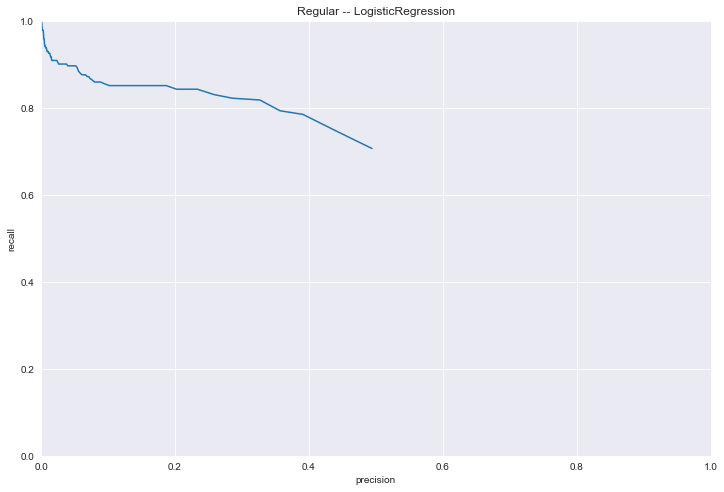

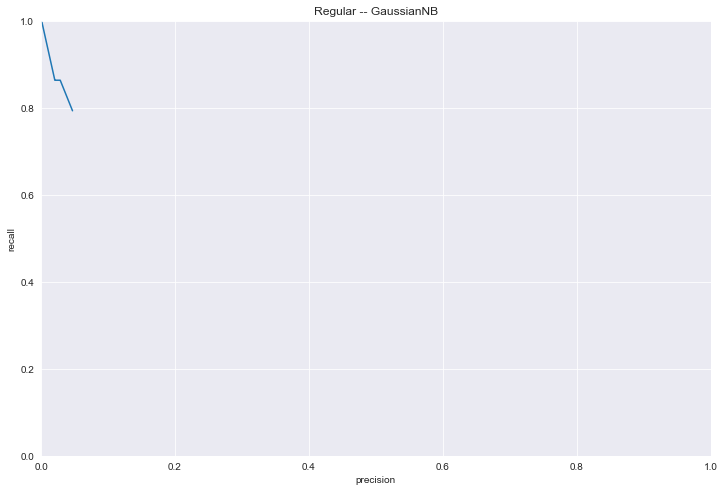

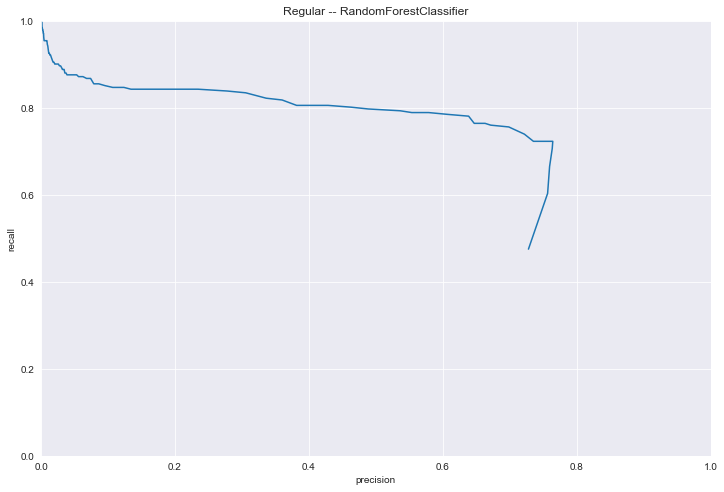

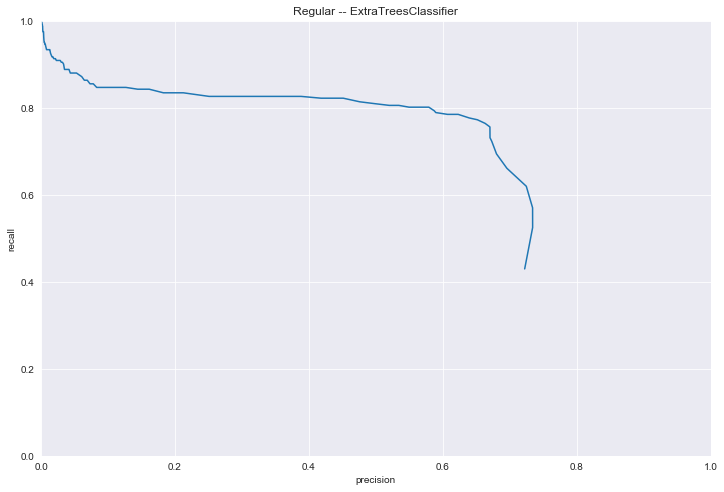

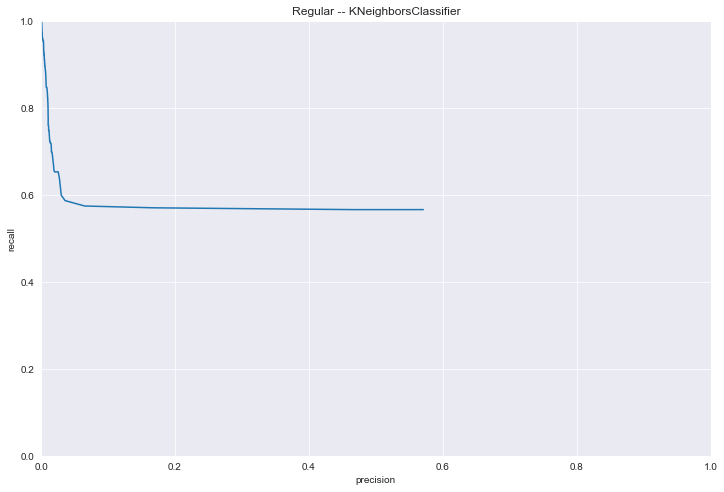

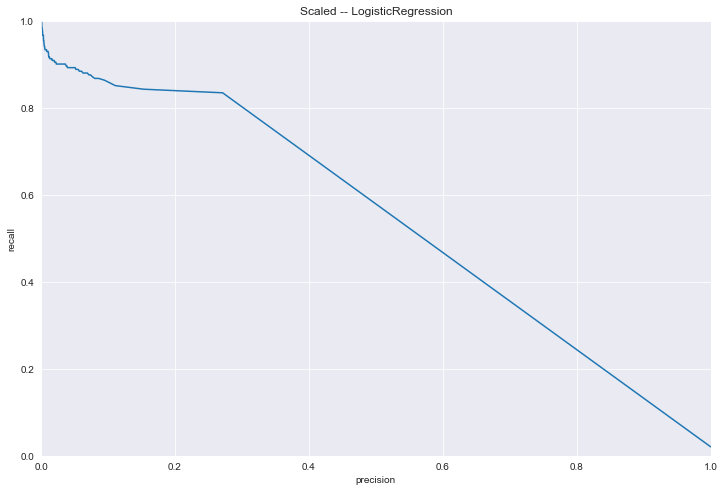

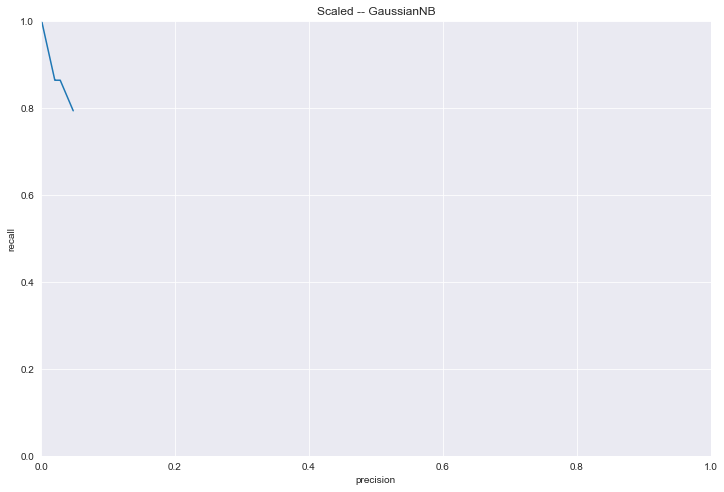

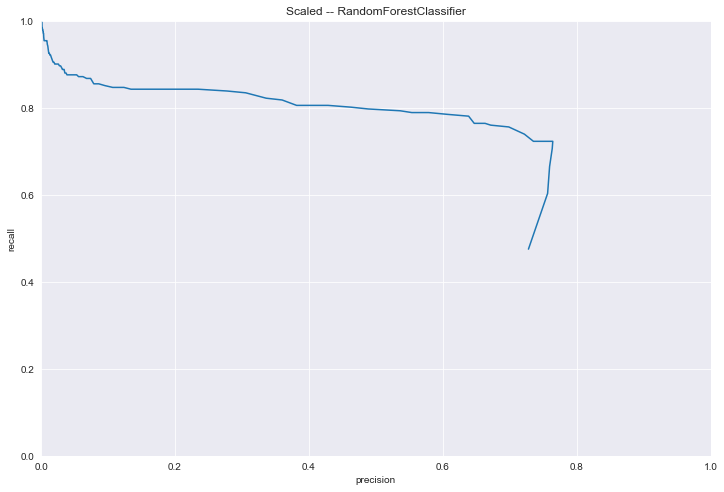

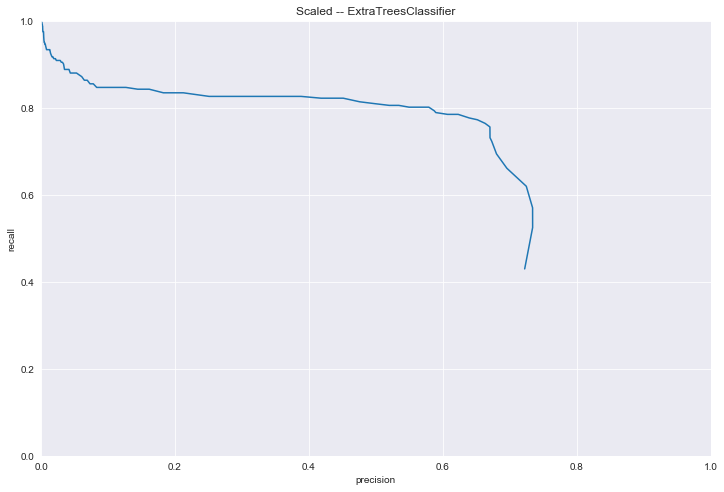

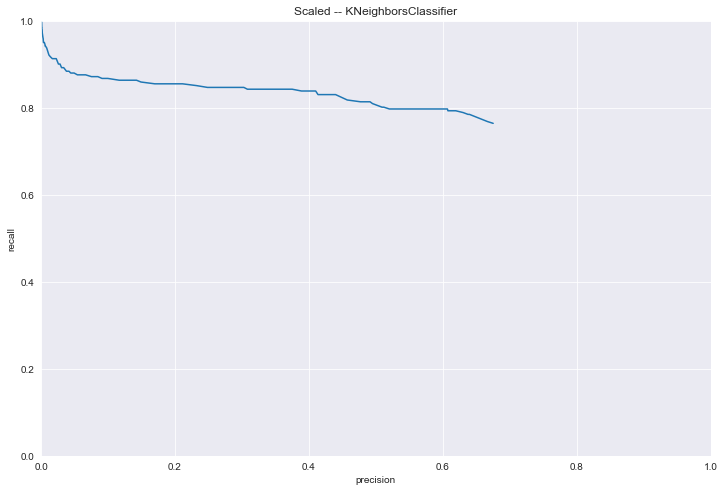

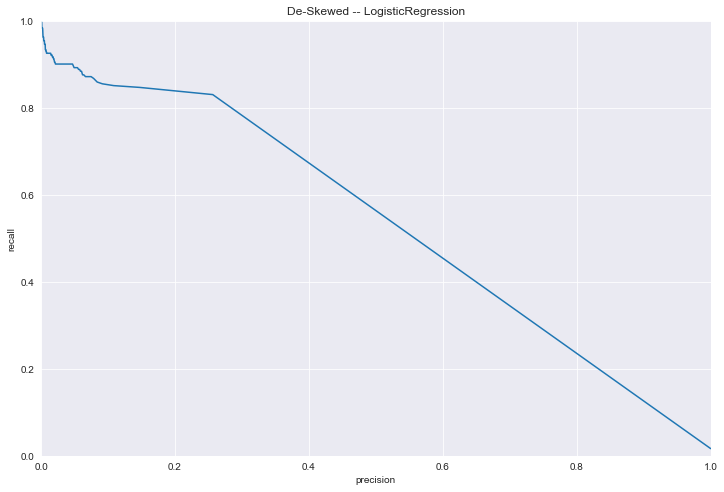

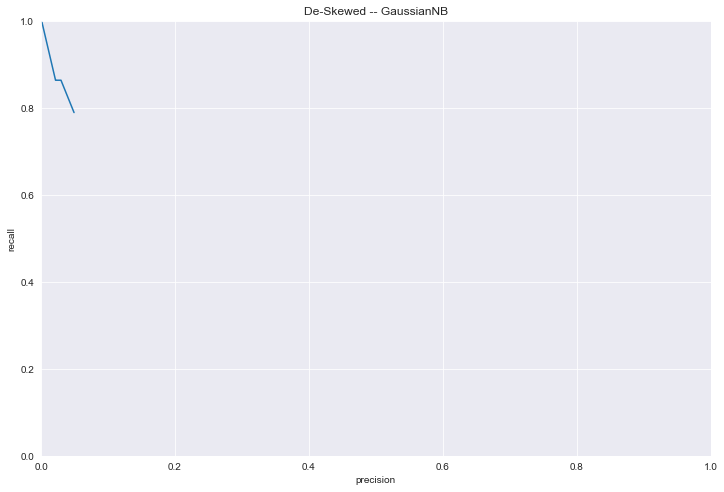

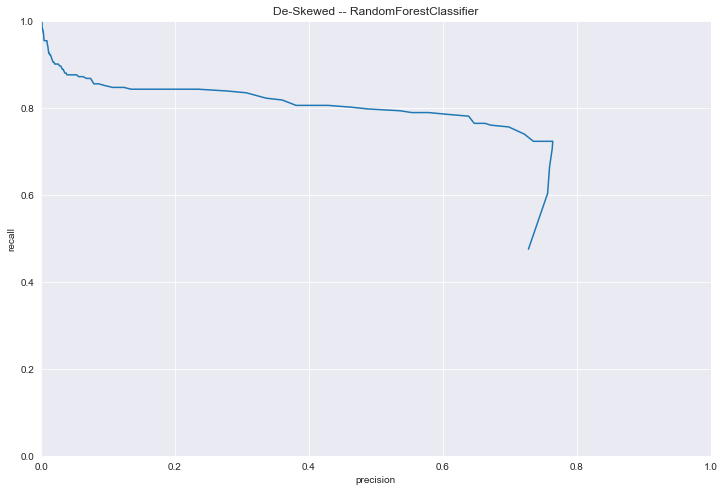

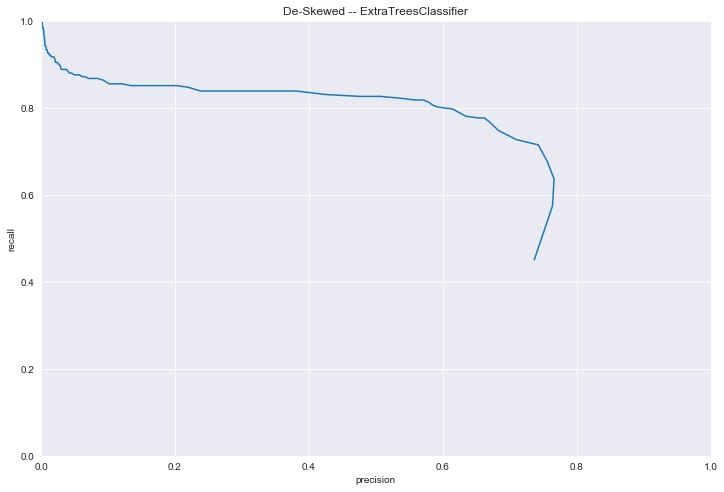

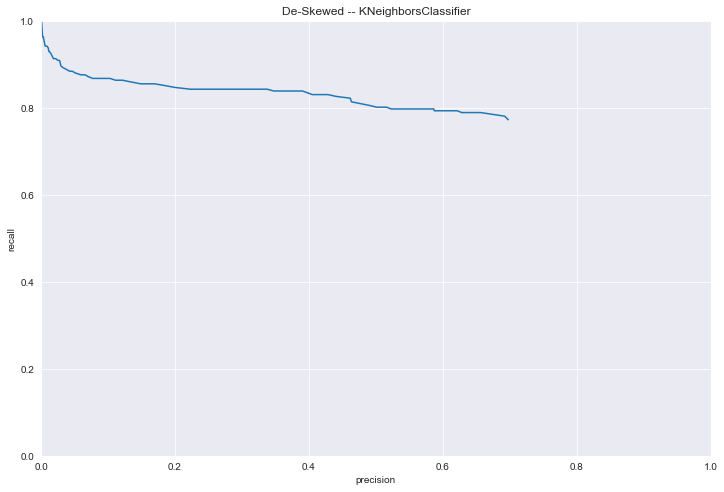

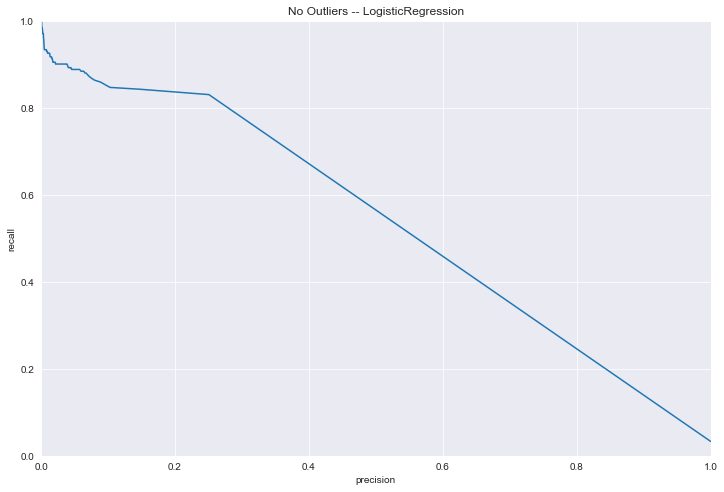

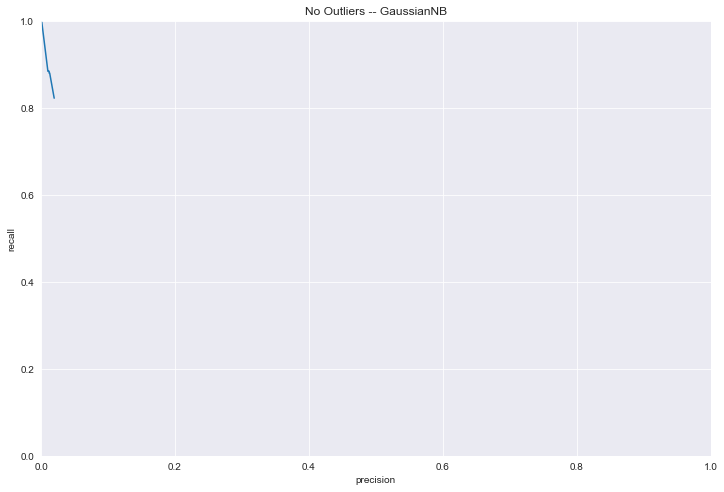

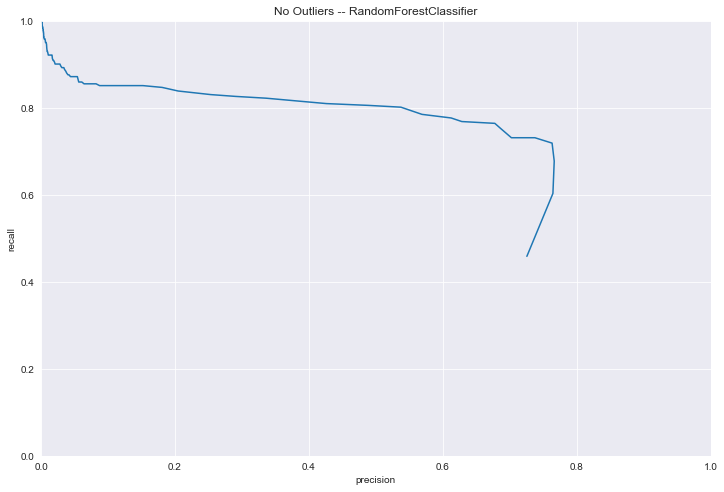

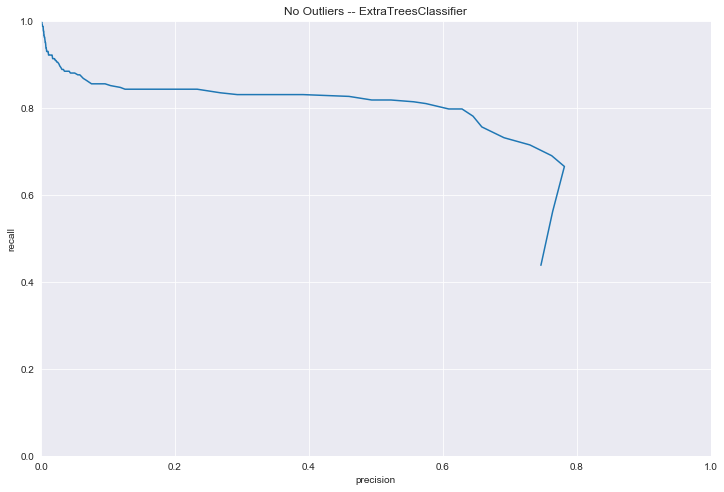

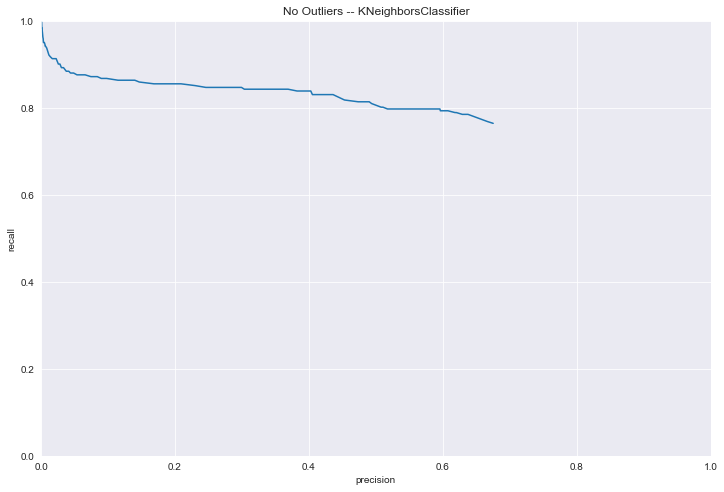

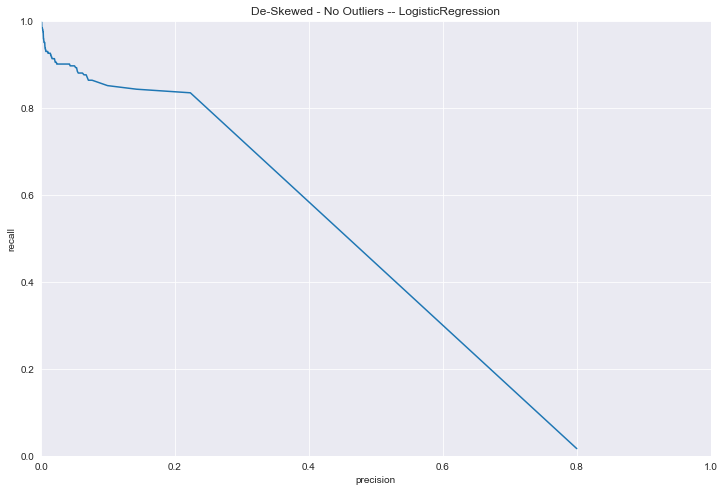

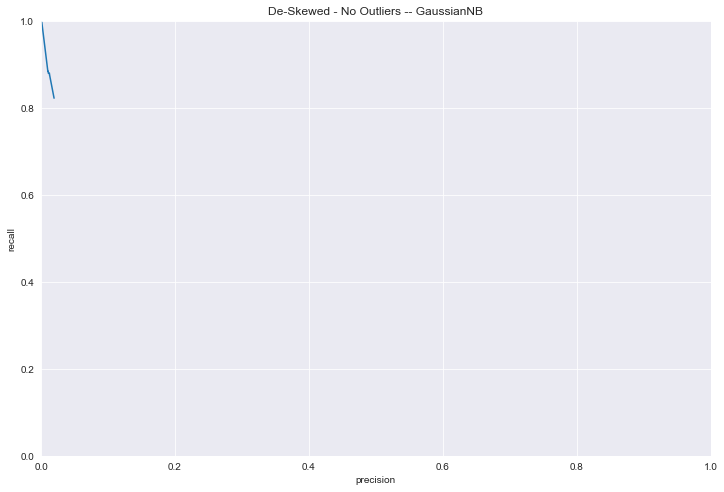

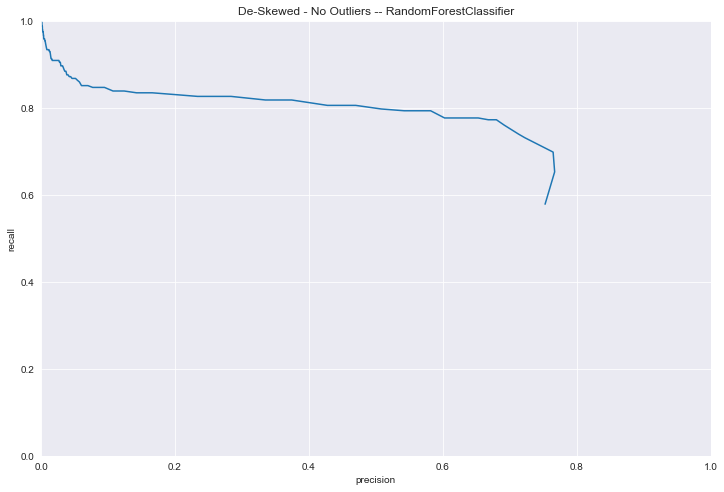

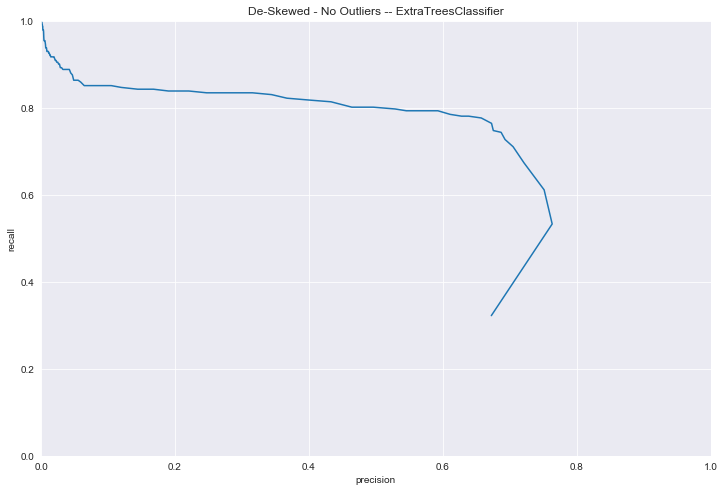

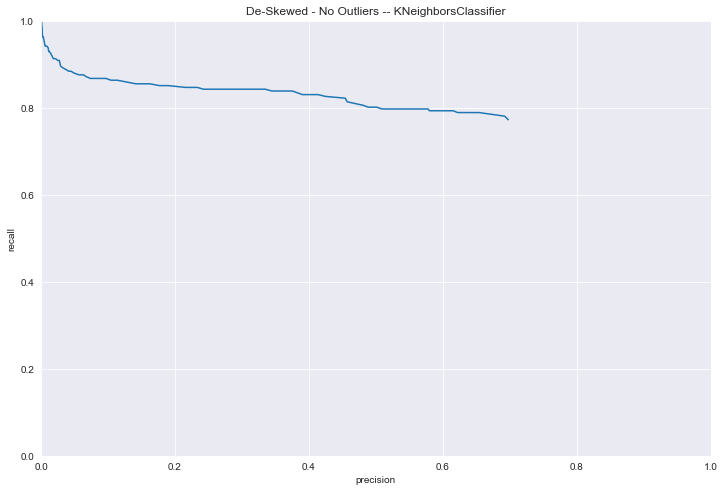

In [14]:
for data_transformed, transform_label in zip([df, scaled_df, deskewed, scaled_df, deskewed],
                                             ['Regular', 'Scaled', 'De-Skewed', 'No Outliers', 'De-Skewed - No Outliers']):
    for clf, params in zip(
        [
            LogisticRegression(), 
            GaussianNB(), 
            RandomForestClassifier(random_state = SEED),
            ExtraTreesClassifier(random_state = SEED),
            KNeighborsClassifier()
        ],
        [
            lr_params, 
            nb_params,
            tree_params,
            tree_params,
            knn_params
            
        ]
        
    ):
        model_name = str(clf.__class__).split('.')[-1].strip("'>")
        label = transform_label + ' -- ' + model_name
        print('EVALUATING:', label)
        print()
        # get samples and potentially remove outliers for related transforms
        train_us, test_us = get_sample(data_transformed, n_undersample=250)
        if transform_label in ['No Outliers', 'De-Skewed - No Outliers']:
            train_us = cfh.remove_outliers(train_us, S=5, subset_rows=train_us.Class==0, subset_cols=sub_cols)
        print()
        plt.figure(figsize=(12,8))
        mod, x, y, stats = evaluate_classifier(train_us, test_us, clf, params)
        plt.title(label)
        results_us[label] = (mod,x,y,stats)
        print('===================================================')
        print('===================================================')
        print()

In [15]:
# Save Results
for k, (mod,x,y,stats) in results_us.items():
    joblib.dump(mod, 'saved_models/undersampled/'+k+'.joblib')
    with open('saved_models/undersampled/'+k+' Stats.json', 'w') as f:
        json.dump(stats, f)

Undersampling seems to result in poorer performing models all around. This is most likely due to such small sample size for the minority class. Cutting down a dataset of ~ 200K to only 300 samples loses so much information encoded 
in the majority class. The tree models are slightly resiliant to the information loss but still perform much worse than on the full dataset.

___Oversample Minority___

In [16]:
results_os = {}

EVALUATING: Regular -- LogisticRegression

Train Distribution of Target Class
1    25000
0    25000
Name: Class, dtype: int64

Best Params: {'C': 0.1, 'penalty': 'l1'}
Best Score: 0.9867777792
F1: 0.6042944785276073
Recall: 0.8008130081300813
Precision: 0.4852216748768473
Threshold: 0.99

EVALUATING: Regular -- GaussianNB

Train Distribution of Target Class
1    25000
0    25000
Name: Class, dtype: int64

Best Params: {'priors': (0.9, 0.09999999999999998)}
Best Score: 0.9751407616000001
F1: 0.06347171020996956
Recall: 0.8048780487804879
Precision: 0.033038544969130654
Threshold: 0.99

EVALUATING: Regular -- RandomForestClassifier

Train Distribution of Target Class
1    25000
0    25000
Name: Class, dtype: int64

Best Params: {'criterion': 'gini', 'max_depth': 25, 'n_estimators': 150}
Best Score: 0.9999020448000001
F1: 0.7510204081632651
Recall: 0.7479674796747967
Precision: 0.7540983606557377
Threshold: 0.98

EVALUATING: Regular -- ExtraTreesClassifier

Train Distribution of Target Cl

/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Best Params: {'C': 0.1, 'penalty': 'l1'}
Best Score: 0.9872117925598984
F1: 0.35044247787610616
Recall: 0.8048780487804879
Precision: 0.2239819004524887
Threshold: 0.99

EVALUATING: De-Skewed - No Outliers -- GaussianNB

Train Distribution of Target Class
1    25000
0    25000
Name: Class, dtype: int64



/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Best Params: {'priors': (0.9, 0.09999999999999998)}
Best Score: 0.980831655791983
F1: 0.033287101248266296
Recall: 0.8292682926829268
Precision: 0.016984430938306552
Threshold: 0.99

EVALUATING: De-Skewed - No Outliers -- RandomForestClassifier

Train Distribution of Target Class
1    25000
0    25000
Name: Class, dtype: int64



/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Best Params: {'criterion': 'gini', 'max_depth': 25, 'n_estimators': 250}
Best Score: 0.9999357731176883
F1: 0.7541666666666668
Recall: 0.7357723577235772
Precision: 0.7735042735042735
Threshold: 0.99

EVALUATING: De-Skewed - No Outliers -- ExtraTreesClassifier

Train Distribution of Target Class
1    25000
0    25000
Name: Class, dtype: int64



/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Best Params: {'criterion': 'entropy', 'max_depth': 25, 'n_estimators': 250}
Best Score: 0.9999678943695535
F1: 0.7303609341825902
Recall: 0.6991869918699187
Precision: 0.7644444444444445
Threshold: 0.99

EVALUATING: De-Skewed - No Outliers -- KNeighborsClassifier

Train Distribution of Target Class
1    25000
0    25000
Name: Class, dtype: int64



/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Best Params: {'n_neighbors': 25, 'weights': 'distance'}
Best Score: 0.9979079440157288
F1: 0.14329037149355572
Recall: 0.7682926829268293
Precision: 0.07901337792642141
Threshold: 0.96



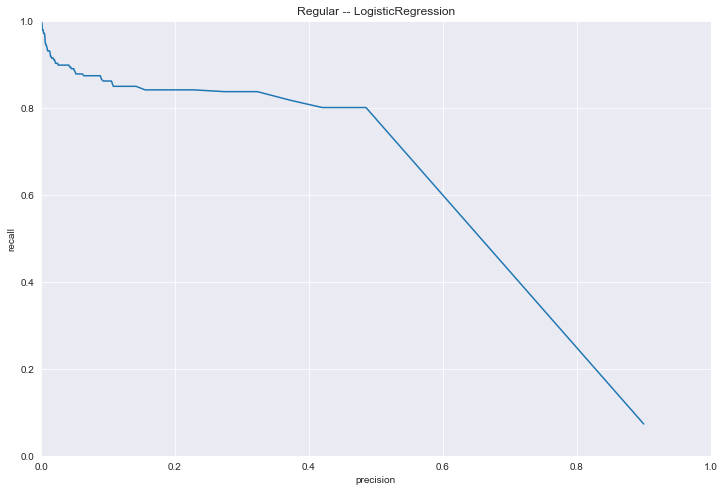

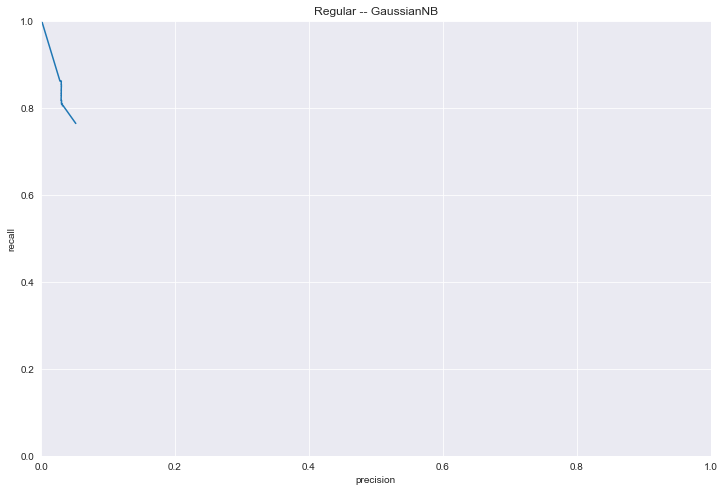

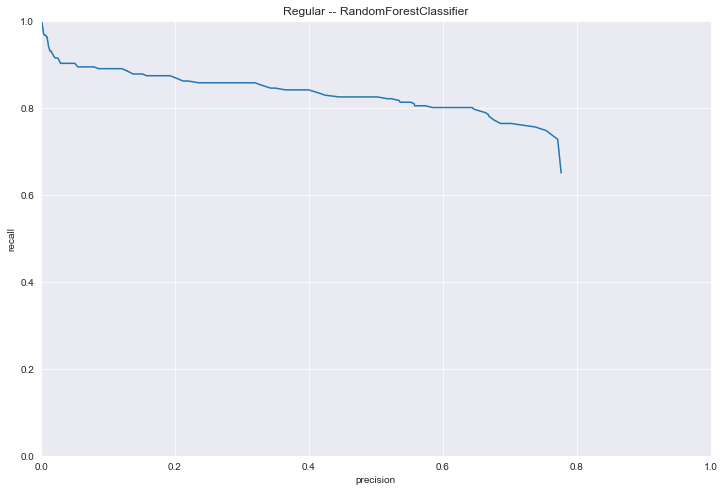

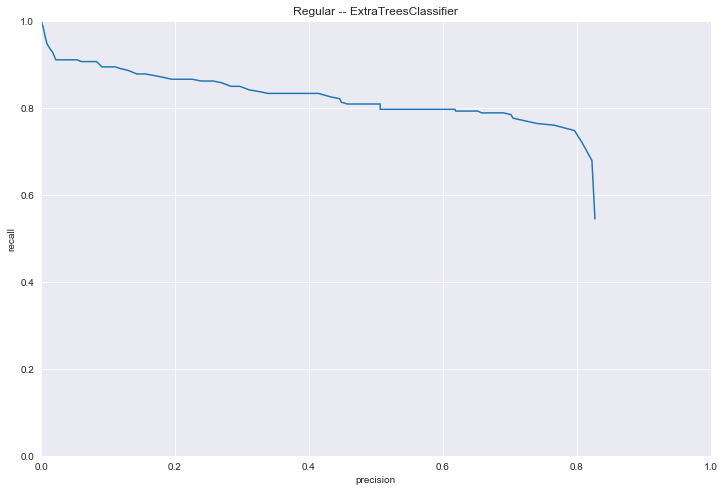

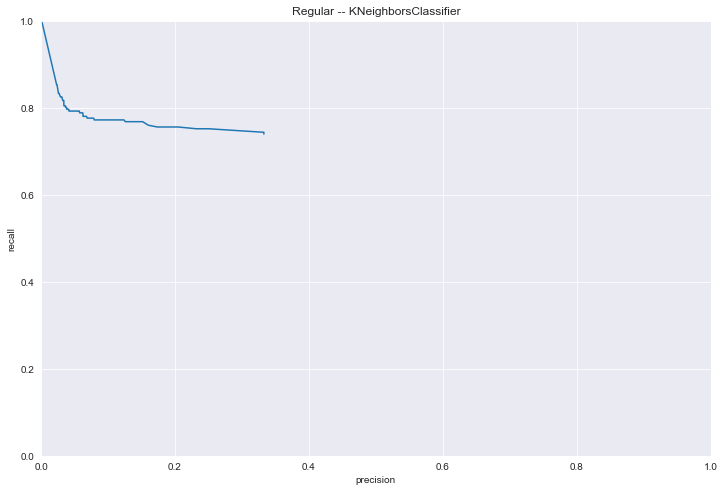

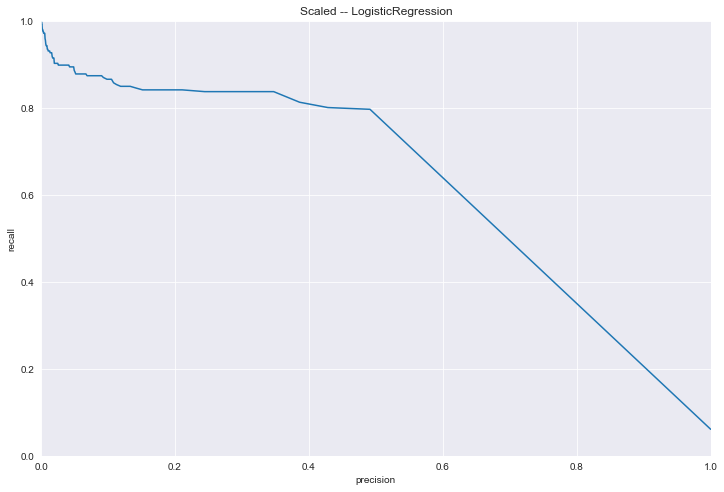

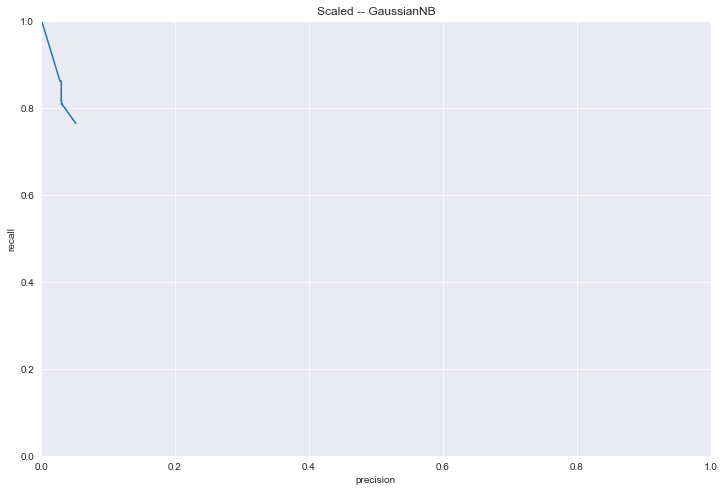

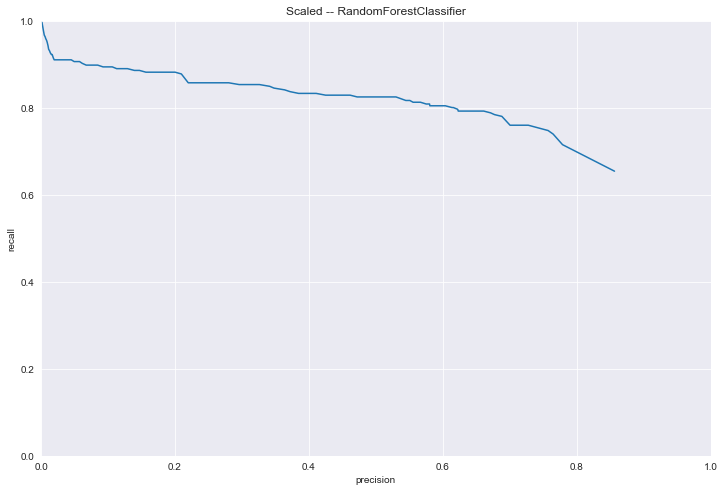

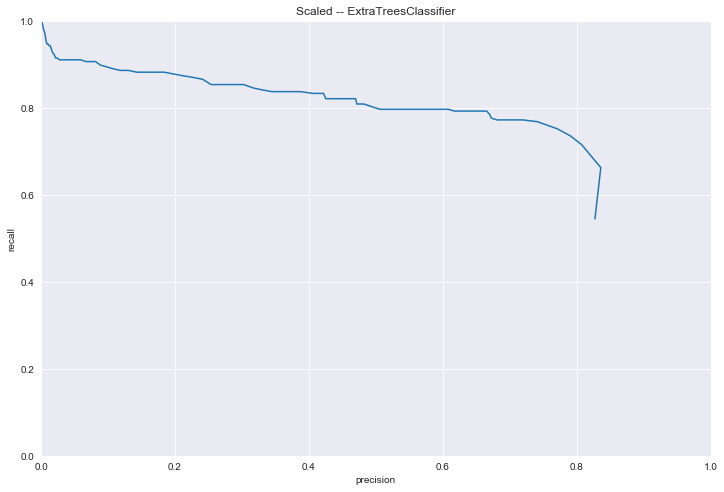

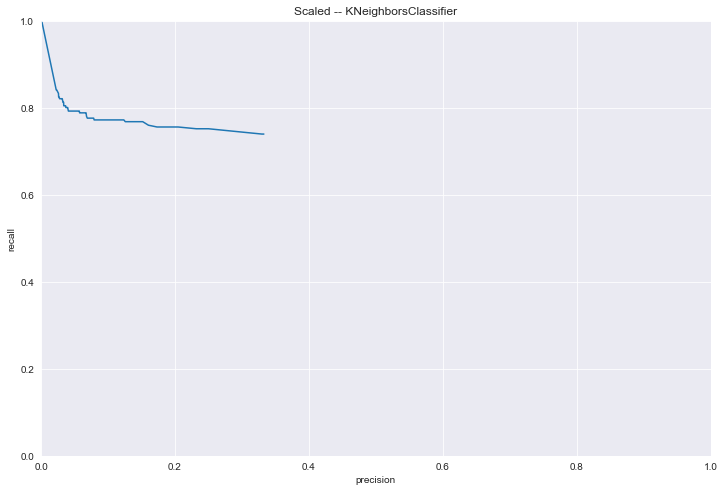

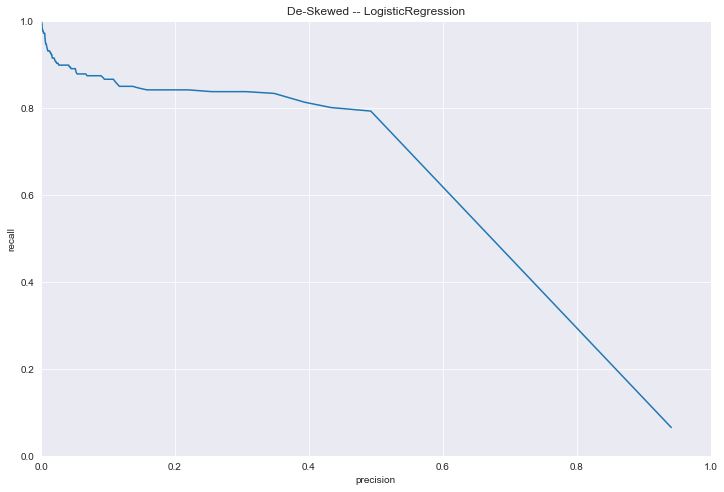

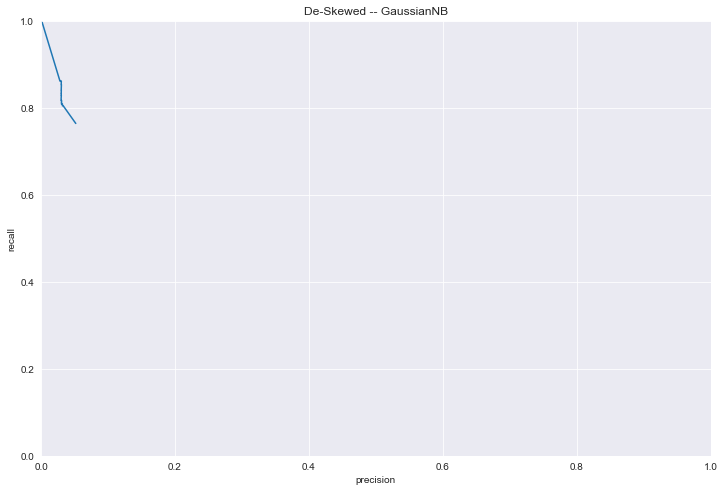

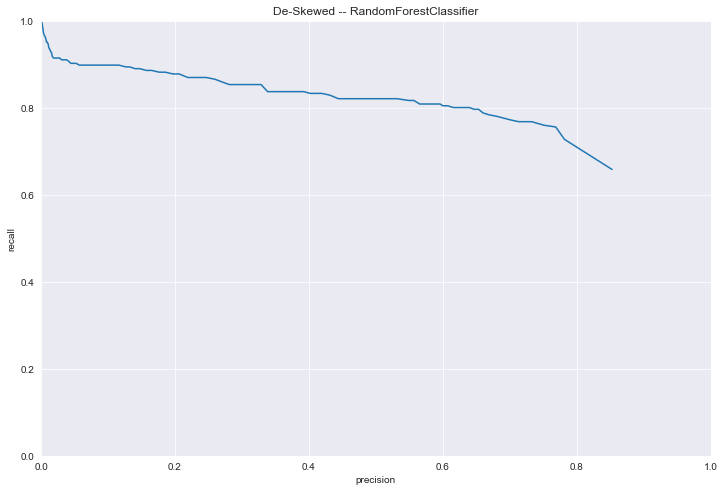

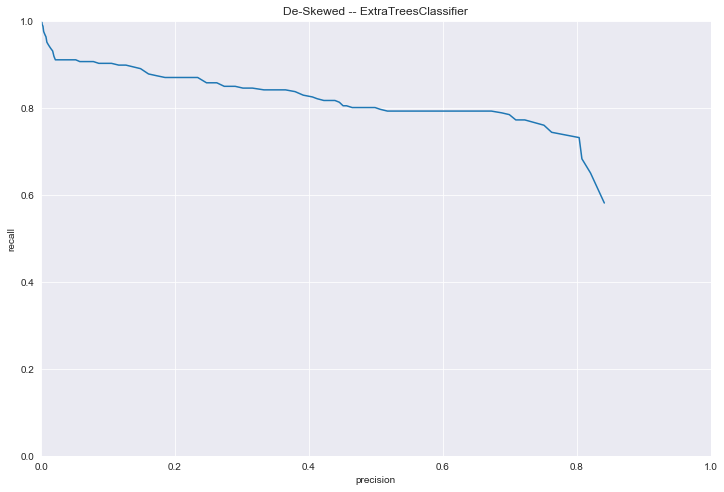

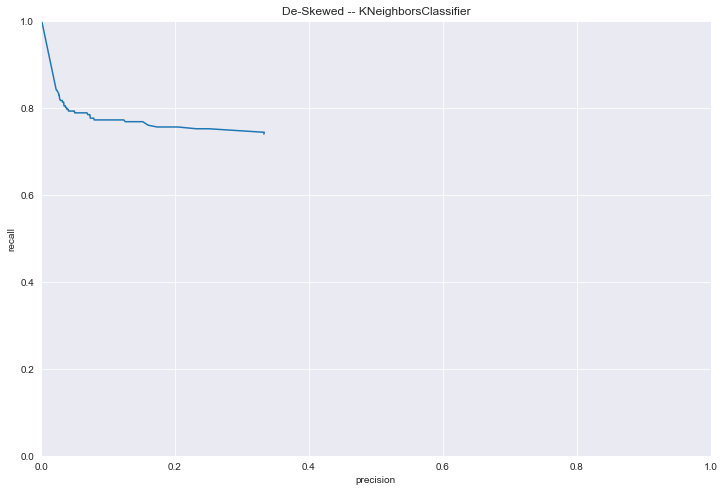

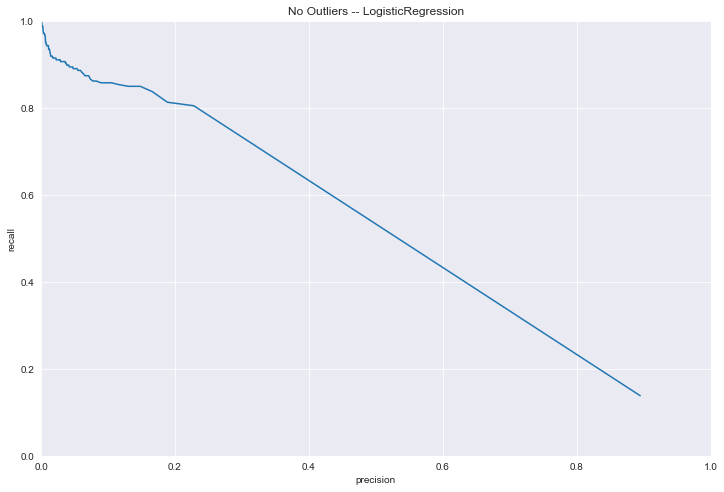

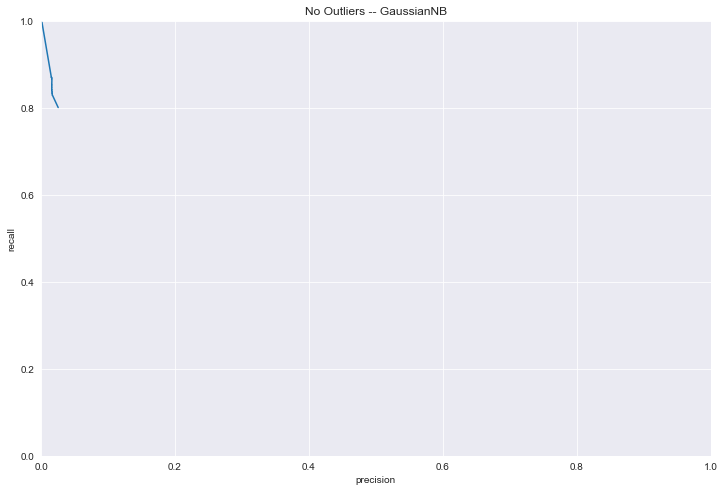

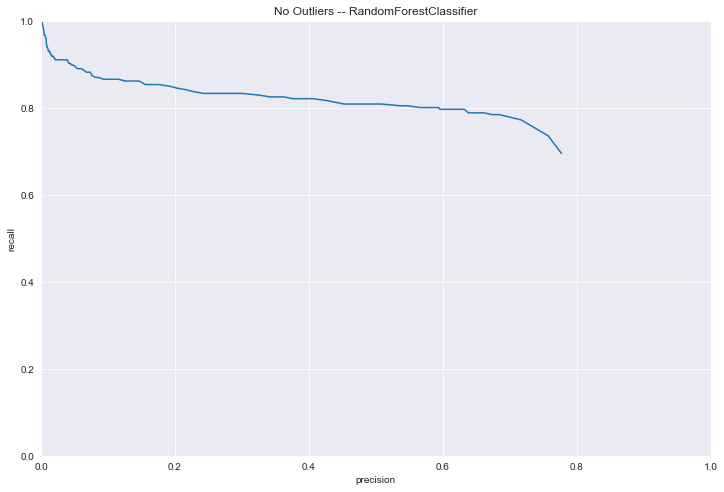

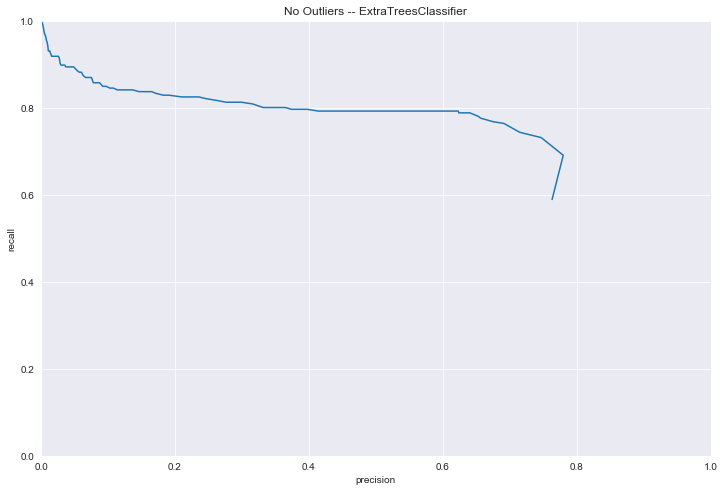

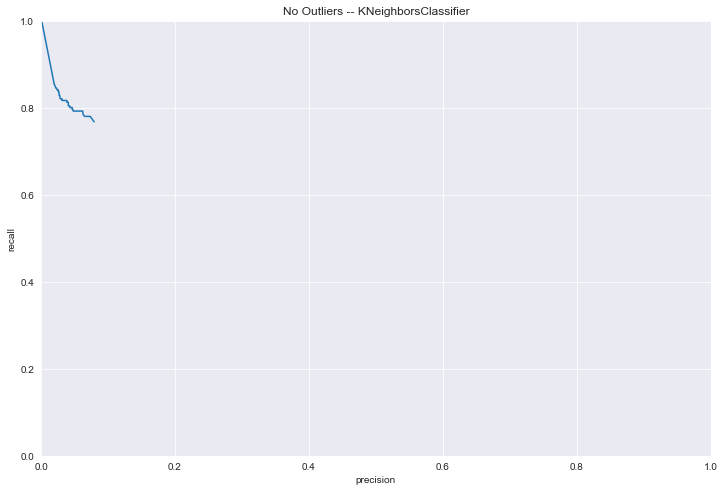

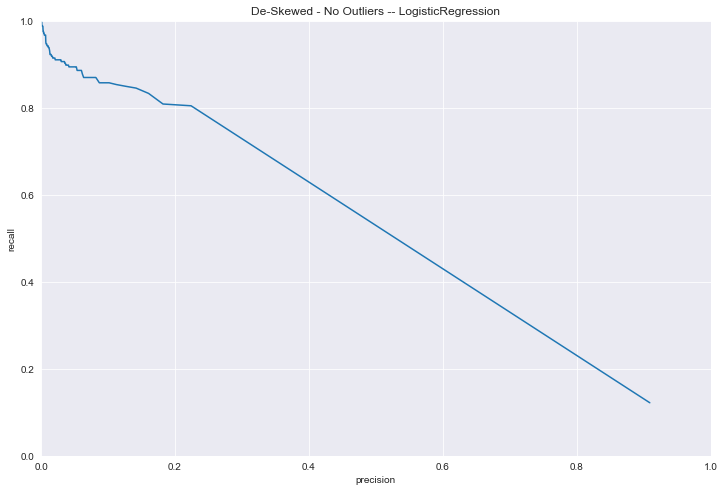

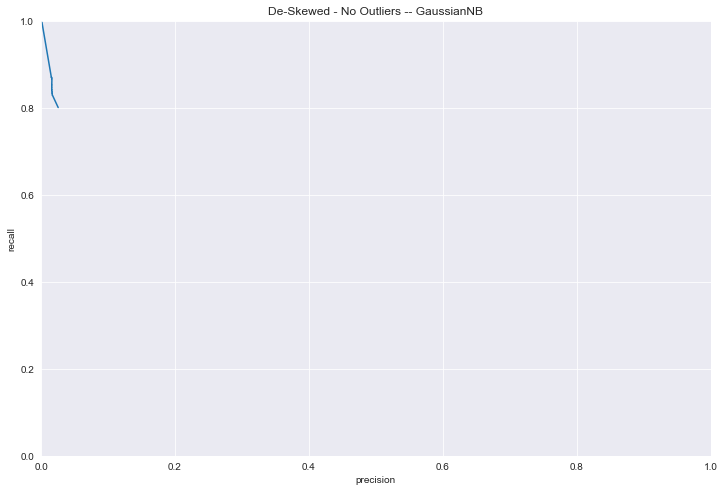

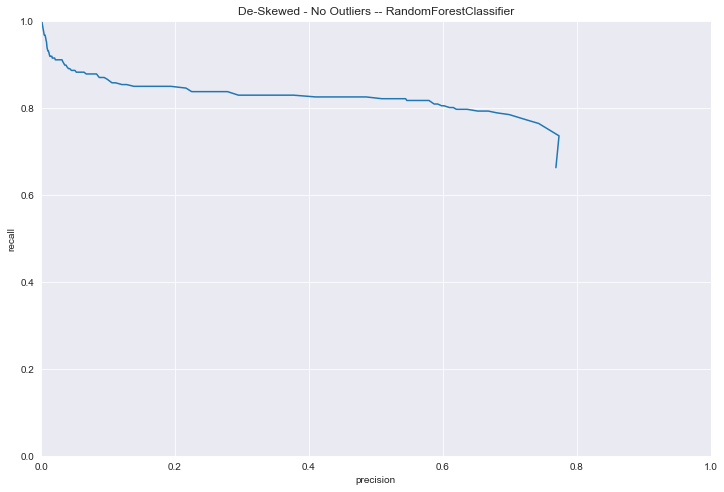

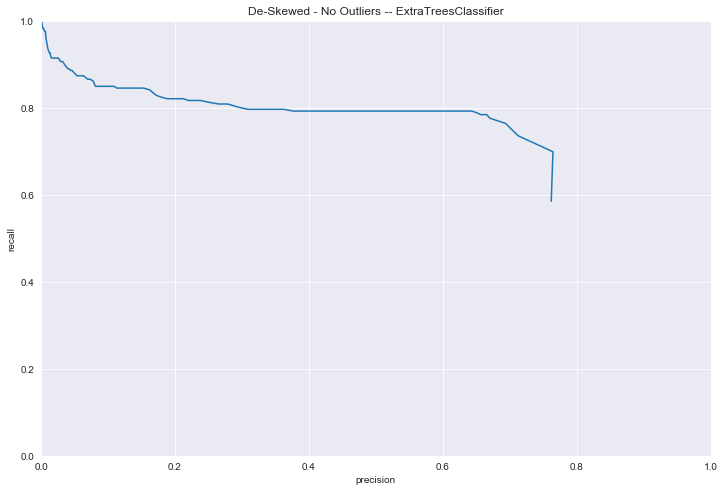

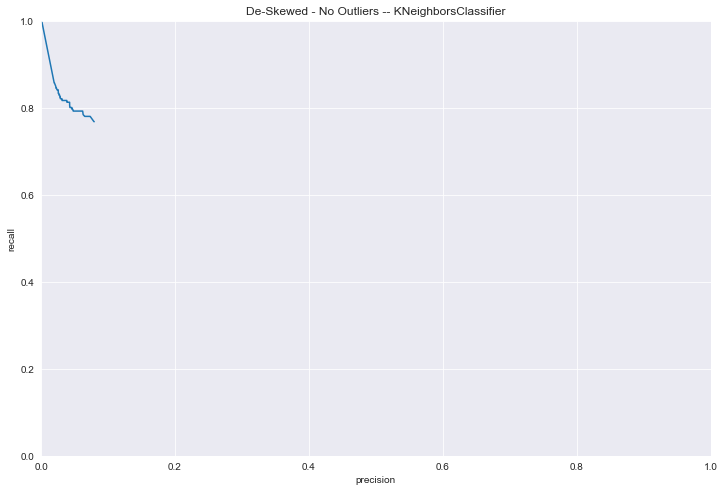

In [17]:
for data_transformed, transform_label in zip([df, scaled_df, deskewed, scaled_df, deskewed],
                                             ['Regular', 'Scaled', 'De-Skewed', 'No Outliers', 'De-Skewed - No Outliers']):
    for clf, params in zip(
        [
            LogisticRegression(), 
            GaussianNB(), 
            RandomForestClassifier(random_state = SEED),
            ExtraTreesClassifier(random_state = SEED),
            KNeighborsClassifier()
        ],
        [
            lr_params, 
            nb_params,
            tree_params,
            tree_params,
            knn_params
            
        ]
        
    ):
        model_name = str(clf.__class__).split('.')[-1].strip("'>")
        label = transform_label + ' -- ' + model_name
        print('EVALUATING:', label)
        print()
        # get samples
        train_os, test_os = get_sample(df, n_oversample=50000)
        train_os.reset_index(drop=True, inplace=True)
        # randomly add noise to training samples (for minority class)
        rows = train_os[train_os.Class==1].sample(frac=0.5).index
        cols = train_os.columns[1:30]
        train_os.loc[rows, cols] += np.random.randn(len(rows), len(cols))
        # remove outliers for corresponding iterations
        if transform_label in ['No Outliers', 'De-Skewed - No Outliers']:
            train_os = cfh.remove_outliers(train_os, S=5, subset_rows=train_os.Class==0, subset_cols=sub_cols)
        print()
        plt.figure(figsize=(12,8))
        mod, x, y, stats = evaluate_classifier(train_os, test_os, clf, params)
        plt.title(label)
        results_os[label] = (mod,x,y,stats)
        print('===================================================')
        print('===================================================')
        print()

In [18]:
# Save Results
for k, (mod,x,y,stats) in results_os.items():
    joblib.dump(mod, 'saved_models/oversampled/'+k+'.joblib')
    with open('saved_models/oversampled/'+k+' Stats.json', 'w') as f:
        json.dump(stats, f)

Over Sampling performs slightly better than undersampling as you still retain enough information to identify the majority class, however it still underperforms compared to the regular sampling. Some tuning of
class distribution would be required to improve the oversampling scores, but this is easily accomplished by tuning the weights in the loss function as set by the `class_weight` parameter in the RandomForestClassifier algorithm.

### Take Away?